# **QLoRA Fine-Tuning Notebook**

### **QLoRA Fine-Tuning Readme:**

For more information on QLoRA Fine-Tuning, refer to the [QLoRA Fine-Tuning Readme](../qlora_finetuning_readme.md).

### **About This Notebook:**

This notebook demonstrates `QLoRA Fine-Tuning`. Compared to the [LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning.ipynb), the following modifications have been made:

1. The `bitsandbytes==0.44.1` library is installed to enable model quantization.
2. Base model weights are loaded into VRAM with `4-bit quantization`. Specifically, the model is first quantized to 8-bit and then further quantized to 4-bit using NF4 (Normal Float 4-bit) quantization. During the computation phase, 4-bit quantized weights are upcast to bfloat16 for operations.
3. The base model is loaded with the `eager` attention implementation. While this provides less VRAM savings compared to the `flash_attention_2` implementation used in LoRA fine-tuning, it avoids the mixed-precision issues encountered when using `flash_attention_2` in QLoRA fine-tuning.

### **Supporting Python Files:**

This notebook utilizes the following external Python files:

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_qlora.py`: Contains utility functions specific to QLoRA fine-tuning. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 150GB (model checkpoints storage)
- `GPU Setup`: 1 Nvidia RTX A4000 GPU (16GB VRAM)

---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook
!pip install bitsandbytes==0.44.1 -q -U     # to support quantization for enabling QLoRA

Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training**

## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases) 

In [1]:
import my_login
# Log in to the Hugging Face account to access the Idefics2 model and the dataset
my_login.login_hf()
# Log in to the Weights & Biases account to enable tracking of training progress
my_login.login_wandb()

==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 2.2 Load the Processor (Tokenizer) and the Base Model

In [2]:
%%writefile my_utils_qlora.py
#--------------- Functions in QLoRA Fine Tuning ---------------
# 1) Create Quantization Config for QLoRA
# !pip install bitsandbytes==0.44.1 -q -U
import torch
from transformers import BitsAndBytesConfig
def create_quantization_config():
    print("==> Creating Quantization Configuration...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,                       # Load model weights in 4-bit precision
        bnb_4bit_use_double_quant=True,          # First quantize weights to 8-bit, then to 4-bit
        bnb_4bit_quant_type="nf4",               # Use NF4 (Normal Float 4-bit) quantization
        bnb_4bit_compute_dtype=torch.bfloat16    # Upcast 4-bit precision weights to bfloat16 during computation
    )
    return bnb_config

Writing my_utils_qlora.py


In [3]:
import my_utils
import my_utils_qlora

# Load processor
processor = my_utils.load_processor()
my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')

# Load model
bnb_config = my_utils_qlora.create_quantization_config()
base_model = my_utils.load_model(quantization_config=bnb_config)
my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')

==> Loading processor...


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32003, bos_token: <s>, eos_token: </s>, pad_token: <unk>
==> For complete processor info, refer to ./results/model_info/original_processor_info.txt.
==> Creating Quantization Configuration...
==> Loading model...


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/base_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (663552, torch.uint8, cuda, False)
model.vision_model.encoder.layers.0.self_attn.k_proj.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.0.self_attn.v_proj.weight (663552, torch.uint8, cuda, False)
model.vision_model.encoder.layers.0.self_attn.v_proj.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.

## 2.3 Load the Dataset

In [4]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

==> Loading hf dataset...


README.md:   0%|          | 0.00/648 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/82 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/74 [00:00<?, ? examples/s]

## 2.4 Perform Inference with the Base Model to Establish a Baseline

==> Performing batch inference and saving results to ./results/inference_results/inference_results_before_finetuning.csv ...
==> [Batch: 1/37] Data in batch: 2
==> [Batch: 1/37][Data: 1/2] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


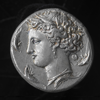

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a coin. On this coin there is a picture of a person.
==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American coinage. Disappointed by the mundane designs of contemporary coins, he envisioned a more artistic approach that would rival the elegance of clas

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


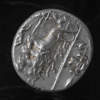

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a coin.
==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen such as Kimon and Euinatos. With its striking high relief, this coin has fascinated collectors for more than two millennia, prompting inquiries into the techniques used by the Greeks to achieve such intricate designs without modern tools. A significant figure connected to this coin is Theodore Roosevelt, who, while recognized for his political reform efforts, also sought to elevate the quality of American currency. Frustrated by the lackluster designs of contemporary coins, he advocated for a more artistic 

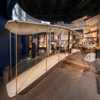

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A full size replica of the Wright brothers first plane is on display here.
==> Ground truth answer: This exhibit showcases the remarkable 1903 Wright Flyer, the first successful powered airplane, which heralded the beginning of the aerial age. Designed by Wilbur and Orville Wright, this biplane features a 12-horsepower Wright horizontal four-cylinder engine that drives two pusher propellers through a chain-and-sprocket transmission. Notably, it employs linear skids for landing gear and is finished with natural fabric, devoid of any sealant or paint. The Wright brothers' groundbreaking achievement on December 17, 1903, at Kitty Hawk, North Carolina, included a 12-second flight covering 36 meters, with Orville pi

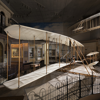

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A collection of old fashioned planes are on display in a museum.
==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the dawn of powered flight. Built by the Wright brothers, Wilbur and Orville, this biplane is powered by a 12-horsepower engine that operates two pusher propellers via a sprocket-and-chain system. Its unique landing gear consists of linear skids, and it is covered in natural fabric, without any paint or sealant. The Flyer made its historic first flight on December 17, 1903, in Kitty Hawk, North Carolina, with Orville at the controls for a brief 12-second journey. The Wrights' innovative methods, including wind tunnel te

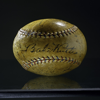

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a ball on the surface.
==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York Yankees, signed by iconic players including Hall of Famers Babe Ruth and Lou Gehrig. Ruth, known for his extraordinary hitting prowess, and Gehrig, celebrated for his record of 2,130 consecutive games played, both left an indelible mark on the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), which is often referred to as Lou Gehrig's disease, showcased his incredible humility and resilience, inspiring many during his illness. The baseball, which measures approximately 3 inches in diameter, is crafted with a cork center, wool layers, and

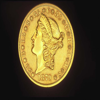

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a coin with some text and a picture of a woman.
==> Ground truth answer: This exhibit features a remarkable coin from the United States Mint in Philadelphia, showcasing a unique design that reflects a significant moment in American numismatic history. The obverse displays the Liberty head facing left, with the date inscribed below and details about weight and fineness surrounding it. The reverse features an eagle, similar to the standard twenty-dollar coin, but replaces the traditional motto "IN GOD WE TRUST" with "DEO EST GLORIA." This coin was part of a series inspired by the desire to enhance the competitiveness of American currency in global markets, alongside the creation of the fo

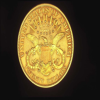

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: United States of America Twenty Dollars.
==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United States Mint in Philadelphia, showcasing both artistic and economic significance. The coin features a Liberty head on the obverse, with the date inscribed below and weight and fineness details surrounding it. On the reverse, an eagle is depicted, but intriguingly, it bears the Latin phrase "DEO EST GLORIA" instead of the more familiar "IN GOD WE TRUST." This design was part of an initiative aimed at improving the international appeal and convertibility of American coins, paralleling the introduction of the four-dollar gold coin, or Stella. Only nine gold examp

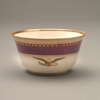

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a cup.
==> Ground truth answer: The exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. This ceramic cup, adorned in purple with white and gold trim, was left behind by President Lincoln on a windowsill at the White House on the evening of April 14, 1865, just before he attended Ford's Theatre. A White House servant preserved this cup as a memento of that tragic night, which marked the end of Lincoln's life and the Civil War. In 1887, Captain D.W. Taylor gifted it to Robert Todd Lincoln, the president's eldest son, ensuring its legacy as a cherished family heirloom. The cup is now part of the Smithsonian's National Museum of American History, sho

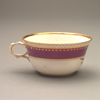

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a cup with a handle.
==> Ground truth answer: This exhibit showcases a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887. The cup was a gift from Captain D.W. Taylor to Robert Todd Lincoln, the president's eldest son. It holds a somber history, as it was left behind by Lincoln on April 14, 1865, just before he went to Ford's Theatre for what would be his final evening. A White House servant preserved the cup, recognizing its importance as a relic of that fateful night. Crafted from ceramic and featuring a striking purple color with white and gold trim, the cup measures approximately 3 1/4 inches in height. It is housed at the Smithsonian's National Museum o

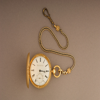

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A watch with a gold chain is on display.
==> Ground truth answer: This exhibit features a remarkable English gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite timepiece served as a notable emblem of his achievements as a lawyer. The watch's movement, crafted in Liverpool, represents the high-quality manufacturing of the era, while the case was made by an unidentified American artisan. Notably, this watch boasts one of the finest movements available in England, capable of maintaining accurate time to within seconds daily. A hidden narrative unfolds with engravings made by watchmaker Jonatha

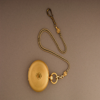

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: Gold watch on a chain with a small loop at the bottom.
==> Ground truth answer: This exhibit showcases Abraham Lincoln's gold pocket watch, acquired in the 1850s from a jeweler named George Chatterton in Springfield, Illinois. Although Lincoln was not typically seen as vain, the watch symbolized his professional success as a lawyer. The watch's movement was produced in Liverpool, a hub for watchmaking at the time, while the case was crafted by an unidentified American shop. Known for its exceptional quality, the watch's movement can keep time within seconds daily. A fascinating aspect of this piece is the hidden message engraved by watchmaker Jonathan Dillon, who, during repairs on April 12,

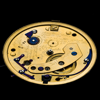

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a watch.
==> Ground truth answer: This display features an exquisite gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a prestigious symbol of his accomplishments as a lawyer. The watch's movement was manufactured in Liverpool, a center of watch production, and it is accompanied by a high-quality case made in America. Remarkably, this timepiece has a movement capable of keeping time to within seconds each day. An intriguing story lies within, as watchmaker Jonathan Dillon, while repairing the watc

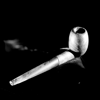

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a pipe on the surface.
==> Ground truth answer: The exhibit features Albert Einstein's iconic pipe, dating back to around 1948. Known for his groundbreaking contributions to theoretical physics, including the theory of relativity, Einstein is also recognized for his distinctive appearance, which prominently included this pipe. Despite reducing his smoking due to medical advice in his later years, he cherished the physical sensation of holding a pipe. This particular pipe shows signs of extensive use, with a noticeable hole worn into its bit. It was gifted to Gina Plunguian, a close friend and admirer of Einstein, before being acquired by the Smithsonian in 1979. This artifact is part of

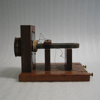

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a machine.
==> Ground truth answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. On March 7, 1876, Bell was awarded the first patent for an apparatus designed to transmit vocal sounds telegraphically. Just three days later, he successfully communicated with his assistant, Thomas Watson, uttering the iconic words, “Mr. Watson, come here, I want to see you.” Featured in this exhibit is one of the original telephones used during a demonstration between Boston and Salem, Massachusetts, on November 26, 1876. This particular device is notable for its iron diaphragm and dual electromagnets, lacking the wooden casing t

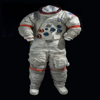

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a mannequin wearing a space suit.
==> Ground truth answer: This exhibit features the Apollo 17 spacesuit, which was worn during the final Apollo mission that successfully landed astronauts on the moon in 1972. Launched on December 7, 1972, aboard a Saturn V rocket, Apollo 17 included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, notable for being the only geologist to have walked on lunar soil. While Evans orbited the moon, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted extensive scientific activities over three days. They completed three moonwalks, collecting a remarkable 110 kil

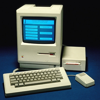

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: An old apple computer with a floppy disc drive and monitor.
==> Ground truth answer: This exhibit features the iconic Apple "Classic" Macintosh Personal Computer, launched in 1984 by Apple Inc. This groundbreaking machine introduced a graphic user interface (GUI) to the world of personal computing, a concept that had its roots in the 1970s at Xerox's Palo Alto Research Center. Apple captured public attention with a memorable Super Bowl XVIII advertisement, marking the Macintosh's debut on January 22, 1984, with a retail price of approximately $2,500. Unlike previous computers that relied on command lines, the Macintosh allowed users to interact with programs through clickable icons, utilizing a single-button mo

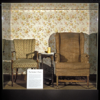

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a glass box. In this box there are two chairs. On this table there is a candle.
==> Ground truth answer: This exhibit features an iconic upholstered wing chair that was prominently used by the character Archie Bunker, portrayed by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, with its distinctive orange-yellow woven fabric and sturdy wooden frame, dates back to the 1940s, although its exact origins remain unclear. Initially acquired from a thrift store in Southern California, it served as a significant prop throughout the show's run from 1971 to 1979, until it was replaced by a reproduction in the final season after being donated to the Smithsonian. "All in th

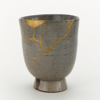

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The cracked glaze on this bowl is known as "Kintsugi", a Japanese philosophy that views damage and repair as part of the history of an object, rather than something to be hidden.
==> Ground truth answer: This exhibit features a remarkable 17th-century tea bowl from the Satsuma ware collection, specifically the White Satsuma type, hailing from Kagoshima prefecture in Japan during the Edo period. The bowl, made of stoneware and finished with a clear, crackled glaze, has a storied past, having been broken and subsequently repaired using the traditional Japanese art of kintsugi, or golden joinery. This technique not only mends the bowl but also accentuates its history by highlighting the cracks with lacquer infused

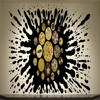

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is an art.
==> Ground truth answer: This exhibition features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. The display showcases 25 circular canvases of varying sizes, meticulously arranged over a large-scale ink splatter pattern that has been applied using a template. Each canvas is adorned with intricate foliate designs painted in black and gold, utilizing Dutch wax printed fabrics. Shonibare's earlier works are characterized by small square canvases in a grid layout, while his more recent pieces, including this one, challenge traditional boundaries with their dynamic black splatter forms. The artwork draws inspiration from Africa's oil resources, often referred to a

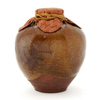

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a brown vase with a brown and red design on it.
==> Ground truth answer: The exhibit titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of collecting. It highlights how collectors engaged with tea-leaf storage jars through the traditional tea ceremony, known as chanoyu, by bestowing names and adorning these jars with exquisite textiles. Central to this theme is the jar named Chigusa, which evolved from a simple Chinese import into a revered object of beauty and contemplation, while still retaining its functional purpose. Notably, 16th-century tea diaries provide insights into the admiration expres

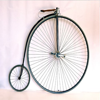

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A bicycle with only one wheel is on display.
==> Ground truth answer: This exhibit at the National Museum of American History celebrates the arrival of spring with a spotlight on an original 1886 Columbia Light Roadster high-wheel bicycle. This remarkable artifact, which originally sold for around $135, was produced by the Pope Manufacturing Co., recognized as the first bicycle manufacturer in the United States. The bicycle features a distinctive configuration with a 53-inch front wheel, supported by 60 spokes, and an 18-inch rear wheel with 20 spokes, available in a range of sizes for riders. Accompanying this bicycle is a historic photograph showcasing one of America's inaugural organized biking tours from 18

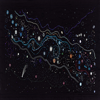

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this image we can see some designs.
==> Ground truth answer: The exhibit titled “Milky Way, Starry Night # 2” features the work of Gwich'in artist Margaret Nazon, who hails from Tsiigehtchic in the Northwest Territories of Canada. Created in 2021, this piece reflects Nazon's lifelong fascination with the stars, a passion that she fully embraced in her art later in life after being inspired by Hubble Space Telescope imagery. Nazon's work is distinctive as it incorporates swirling galaxies, a departure from traditional Gwich'in beadwork, showcasing her unique artistic style. This artwork is part of the “Lights Out: Recovering Our Night Sky” exhibition at the Smithsonian's National Museum of

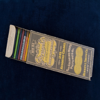

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A box of crayons was made by Binney & Smith.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights a pack of Crayola Crayons from 1903, celebrating a beloved back-to-school tradition. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were crafted using paraffin wax and nontoxic pigments, making them safe and durable for young artists. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," referring to its waxy texture. This particular set, aimed at budding artists, features 28 vibrant colors, including celestial blue and rose pink, and is one of the earliest produced. The packaging, labeled 

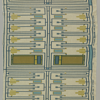

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a poster. In this image we can see a design.
==> Ground truth answer: This exhibit features a striking piece designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The textile, produced by F. Schumacher & Co., a New York-based manufacturer established in 1889, showcases a captivating geometric pattern composed of rectangular blocks in shades of light blue and various olive tones, intricately connected by fine lines of darker blue against an off-white backdrop. The length of the printed linen measures 120 by 57.5 cm (47 1/4 by 22 5/8 inches), with a repeat height of 63.5 cm (25 inches). Additionally, five alternate colorways of this design are affixed to the upper ba

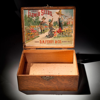

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a wooden box with a picture of three people on it.
==> Ground truth answer: This exhibit features an antique seed box from the late 19th century, specifically from the renowned D.M. Ferry & Co., and is part of the Smithsonian's celebration of National Garden Month. In the 1800s, seed packets were commonly stored in decorative wooden boxes that showcased vibrant labels from seed companies, serving as effective marketing tools on general store counters. This particular seed box, which showcases the D.M. Ferry & Co. label, is significant for its association with the invention of the “commission box,” a display rack that revolutionized retail presentation. Acquired by the Smithsonian in 1986, this artifact 

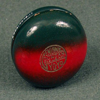

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a red and black ball.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights the captivating story of the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant. Flores had begun manufacturing the toy, which he named “yo-yo,” meaning “come-come” in Tagalog. By early 1929, he had established his own company and produced over 100,000 wooden yo-yos, recognizing the need for demonstrations to attract buyers. Duncan, an astute entrepreneur, quickly saw the toy's potentia

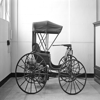

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a black and white image. In the center of the image we can see a vehicle. In the background of the image we can see the wall.
==> Ground truth answer: The exhibit features the 1893-94 Duryea automobile, recognized as one of the earliest American-made vehicles. On September 21, 1893, Frank Duryea conducted a road test of this innovative automobile, which was essentially a second-hand carriage outfitted with a gasoline engine, in Springfield, Massachusetts. In 1896, Frank and his brother Charles, along with financial partners, established the Duryea Motor Wagon Company, marking it as the first American enterprise to manufacture and sell automobiles. This particular model is powered by a one-cylinder, four

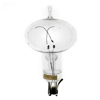

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a bulb.
==> Ground truth answer: This exhibit showcases the Edison Light Bulb, which dates back to 1879 and represents a pivotal moment in the history of innovation. Thomas Edison utilized this carbon-filament bulb during the inaugural public demonstration of his groundbreaking invention—the light bulb, recognized as the first viable electric incandescent lamp. The mechanism of the bulb involves an electrical current flowing through a metal filament wire, which heats up to an intense temperature, ultimately producing light. To safeguard the hot filament from oxygen, the bulb is encased in glass filled with inert gas. This significant demonstration took place at Edison's laboratory in Menlo Park, New Jer

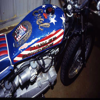

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A Harley Davidson motorcycle is painted in red, white, and blue.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History showcases Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle synonymous with the legendary daredevil's thrilling performances. Evel Knievel, born Robert Craig Knievel, captivated audiences with his death-defying stunts, which often resulted in numerous injuries, including 35 to 40 broken bones throughout his career. His televised daredevil shows, beginning in 1965, featured spectacular jumps over rows of vehicles, including cars, trucks, and buses. The XR-750, constructed from steel, aluminum, and fiberglass, weighs around 300 pounds and was

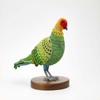

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a toy of a bird.
==> Ground truth answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to highlight the grave issue of species extinction. Through her “Biodiversity Reclamation Suits,” Hope enables common rock pigeons to don the guise of extinct North American birds, symbolically addressing the loss of biodiversity. Utilizing traditional crafting techniques such as carving, embroidery, crochet, and collage, she transforms everyday materials into striking animal sculptures that evoke both playfulness and a deeper emotional response. 

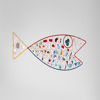

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting.
==> Ground truth answer: This exhibit features "Fish," a captivating work by renowned artist Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who was born into a family of artists and initially trained as a mechanical engineer, transitioned to art after working as a freelance illustrator. His journey took him to Paris, where he became inspired by avant-garde movements and began crafting his signature wire sculptures, often referred to as “drawings in space.” Influenced by the minimalist aesthetic of Piet Mondrian, Calder pioneered the concept of “mobiles” in 1931—kinetic sculptures that move with air currents. He also creat

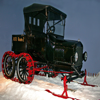

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: An old fashioned vehicle in the snow that has the letters RFD on it.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of early 20th-century rural mail carriers. As these carriers transitioned from horse-drawn sleds to automobiles, they faced challenges navigating deep snow. In response, Virgil White innovated by converting cars into snowmobiles, replacing front tires with skis and rear tires with caterpillar treads. His invention, dubbed the Snowbird, provided a cost-effective solution for winter deliveries, eliminating the need for horses. Initially, White's prototype was based on a

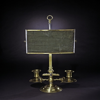

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a stand with a board and two candles.
==> Ground truth answer: This exhibit showcases a significant artifact linked to George Washington, specifically a brass candle stand believed to have been used by him while composing his Farewell Address in 1796. After serving two terms as president, Washington chose to retire to Mount Vernon, where he penned his final thoughts for the nation, urging unity among Americans amidst emerging political factions. His Farewell Address was first published in The American Daily Advertiser and has since been commemorated annually by the United States Senate, where a member reads it aloud in honor of Washington's birthday. The candle stand, featuring a green 

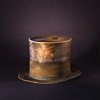

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a hat.
==> Ground truth answer: This exhibit features President Abraham Lincoln's iconic top hat, housed at the Smithsonian's National Museum of American History. Acquired from Washington hat maker J.Y. Davis, this hat stands as a symbol of Lincoln's stature, both physically at 6'4” and in his leadership. Notably, a black silk mourning band adorns the hat, honoring the memory of his son Willie, who passed away in 1862. While the exact date of acquisition remains unknown, the hat was last worn by Lincoln on the fateful night of April 14, 1865, as he headed to Ford's Theatre. Following Lincoln's assassination, the War Department safeguarded the hat along with other belongings left behind, later transferri

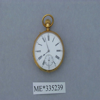

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a pocket watch that is gold.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History features a remarkable timepiece belonging to Helen Keller, who was born on June 27, 1880. Keller, a pivotal figure in advocating for women's suffrage and workers' rights, faced significant challenges after losing her sight and hearing due to illness at a young age. Her breakthrough came with the help of Anne Sullivan, who taught her to communicate. The Swiss-made "touch watch," gifted to Keller by John Hitz in 1892, is designed with pins around its edge to indicate the hours, allowing Keller to tell time even in darkness. This unique watch symbolizes Keller's extraordinary journey 

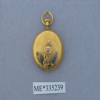

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A gold pocket watch is on display with a small card reading ME 335239.
==> Ground truth answer: This exhibit showcases an extraordinary pocket watch that once belonged to Helen Keller, who was born on June 27, 1880. Keller, known for her advocacy for women's rights and disability rights, faced immense challenges after becoming deaf and blind at a young age. Her life changed dramatically when she met Anne Sullivan, who taught her to communicate. The watch, presented to Keller by John Hitz in 1892, features a unique design with pins around the case that allow the wearer to feel the time, making it particularly suitable for someone who could not see. Keller cherished this watch throughout her l

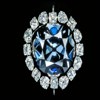

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a diamond.
==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond, characterized by its dark gray-blue hue, is cut in a modified antique cushion style, which enhances its unique visual appeal. Originating from India, this exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category at the National Museum of Natural History. The necklace is cataloged under the USNM number NMNH G3551-00 and is a singular specimen in this exhibit, last modified on September 26, 2022. For more detailed information, you can access the original record through the provi

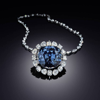

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This necklace contains the largest blue diamond in the world.
==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single primary gem that weighs 45.52 carats. The diamond is distinguished by its dark gray-blue color and is elegantly cut in a modified antique cushion shape, which adds to its vintage charm. Sourced from India, this necklace is a highlight of the Mineral Sciences collection at the National Museum of Natural History, categorized under Gems. The record for this exquisite piece is identified as NMNH G3551-00 and was last updated on September 26, 2022. For further details, you can explore the original record linked here.
==> S

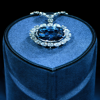

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a necklace on the stand.
==> Ground truth answer: On display is a captivating diamond necklace by Cartier, Inc., featuring a single, striking primary gem that weighs 45.52 carats. This diamond exhibits a dark gray-blue coloration and is expertly cut in a modified antique cushion style, making it a true work of art. The necklace hails from India and is part of the Mineral Sciences department's Gems collection at the National Museum of Natural History. It is cataloged under the USNM number NMNH G3551-00, with the last modification recorded on September 26, 2022. For more in-depth information, you can follow the link to the original rec

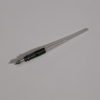

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a pen.
==> Ground truth answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2 of that year. Part of the Smithsonian's National Museum of African American History and Culture collection, this particular pen was among over 70 identical pens distributed to key figures in the Civil Rights Movement. The journey to the enactment of this landmark legislation was fraught with challenges, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. The bill's fate then rested with President Johnson, who oversaw lengthy public hearings and debat

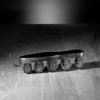

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a toy on the surface.
==> Ground truth answer: This exhibit features the Volito, an innovative inline skate crafted in 1823 by Robert John Tyers. As athletes prepare for the 2014 Winter Olympics, it's intriguing to consider how skaters of the 19th century maintained their skills without the luxury of indoor rinks. The Volito is distinguished by its wooden sole, a single row of five wooden wheels, and a unique curved iron bar at the front, which functioned as a basic brake. What truly set this skate apart was its unequal wheel sizes—larger in the center and smaller at the ends—allowing skaters to navigate turns with greater ease. This remarkable design reflects the ingenuity of early spo

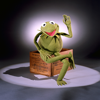

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a toy.
==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who has become an iconic figure in children's television. Kermit, a vibrant green puppet, first appeared in 1955 on the show "Sam and Friends" and has since been the star of "The Muppet Show" and a regular on "Sesame Street." Known for his calm demeanor amidst chaos, Kermit is famous for his poignant song “Bein' Green,” which reflects on the challenges of his color while ultimately celebrating his identity. The puppet is crafted from various materials, including synthetic fiber, felt, and plastic, and measures approximately 27 inches in height. This piece, gifted by Jim Henson Productions, 

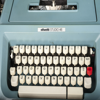

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A close up of the keyboard of an Olivetti Studio 46 typewriter.
==> Ground truth answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a celebrated author in the realm of science fiction. Butler is renowned for her impactful works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the thought-provoking novels Parable of the Sower and Parable of the Talents, along with her acclaimed short story collection, Bloodchild and Other Stories. Her writing uniquely blended elements of African American history with speculative futures and alien psychology, establishing a genre known as Afrofuturism. By centering character

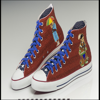

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: These are the shoes which are in brown color.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique blend of traditional and contemporary materials, incorporating cotton canvas, glass beads, and commercial rubber. Measuring 33 x 11 x 15 cm, this piece exemplifies Greeves' innovative approach, showcasing overlay beadwork that reflects the rich cultural heritage of the Kiowa people. Acquired by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, this work is part of a broader collection that highlights the intersection of indigenous

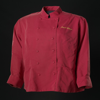

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A red chef's jacket with gold embroidery that reads Leak Chine.
==> Ground truth answer: This exhibit showcases a significant collection from the Smithsonian's National Museum of African American History and Culture, featuring a gift from Dooky Chase's Restaurant and renowned Chef Leah Chase. Celebrated for her assertion that “we changed the world over a bowl of gumbo,” Chase played a pivotal role in the civil rights movement by hosting strategy meetings at her restaurant. Known as "The Queen of Creole Cuisine," she elevated New Orleans Creole cooking to global prominence. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop established by her mother-in-law in the 

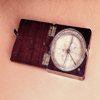

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a compass.
==> Ground truth answer: This exhibit showcases a remarkable silver-plated pocket compass that dates back to around 1804, purchased by Meriwether Lewis in preparation for the historic Lewis and Clark Expedition. Crafted by Philadelphia instrument maker Thomas Whitney, the compass features a mahogany box, a brass rim graduated in degrees, a paper dial, and two brass sight vanes, all housed in a leather carrying case. While it remains uncertain whether Lewis intended the compass for himself or as a gift for his expedition partner, William Clark, it served as a vital navigational tool during their journey. Under President Thomas Jefferson's directive, the Corps of Discovery embarked on their mis

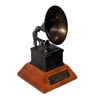

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a trophy.
==> Ground truth answer: This exhibit showcases Bob Newhart's 1960 Grammy Award, a significant artifact from the celebrated comedian's illustrious career. Born on September 5, 1929, in Oak Park, Illinois, Newhart has entertained audiences for over sixty years with his signature deadpan style, cleverly critiquing social norms and the absurdities of American life. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, made history by becoming the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year, making him the only comedian to win a Grammy for Best New Artist. Newhart's influence extended into television, where he starred in iconic 

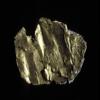

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a piece of gold.
==> Ground truth answer: This exhibit features a remarkable gold nugget from 1848, housed at the Smithsonian's National Museum of American History. Regarded as the first gold piece discovered at Sutter's Mill in California, this nugget played a pivotal role in sparking the infamous gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall noticed a glimmer in the water and retrieved what he identified as a thin scale of pure gold. Following this discovery, Marshall presented the scale to Capt. Joseph L. Folsom, who documented it as the first gold found in Northern California. By August of that year, this nugget, along with other samples, reached Wash

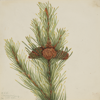

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this image we can see a plant with a flower.
==> Ground truth answer: This exhibit showcases the exquisite watercolor work of Mary Vaux Walcott, particularly her piece titled "Lodgepole Pine (Pinus Contorta murrayana)" created in 1921. Measuring 10 x 7 inches, this artwork is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist encouraged her to paint a rare blooming arnica. Her marriage to Charles Doolittle Walcott, the Smithsonian's Secretary, in 1914 led to summers spent in the Canadian Rockies, where she produced hundreds of watercolor studies of local flora. From 1925 to 1929, a sel

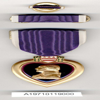

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The purple ribbon is for the military and has a gold frame with a picture of a man.
==> Ground truth answer: This exhibit features the esteemed United States Purple Heart, a distinguished military decoration awarded to those wounded or killed while serving in the U.S. armed forces. The medal is crafted in a striking gold heart shape, showcasing a profile relief of George Washington at its center, set against a rich purple enamel background. Above Washington's bust, the medal is adorned with a shield displaying his family coat of arms. The reverse side bears the embossed inscription "FOR MILITARY MERIT," highlighting the medal's significance. It is suspended from a silk purple ribbon, edged with a white stripe, 

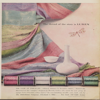

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a poster. On the poster we can see a cloth, vase, bowl, threads and some text.
==> Ground truth answer: This exhibit, titled "The Thread of the Story Is Lurex: The Look of Porcelain," showcases the work of renowned American textile designer Dorothy Liebes, who significantly influenced various design disciplines from the 1930s to the 1960s. Known for her vibrant colors and rich textures, Liebes developed a distinctive style that became synonymous with the modern American aesthetic, referred to as the “Liebes Look.” Her collaborations with notable architects and designers, such as Frank Lloyd Wright and Raymond Loewy, as well as fashion icons like Pauline Trigère, resulted in some of the 

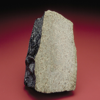

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a rock.
==> Ground truth answer: This exhibit features a fragment of the Nakhla meteorite, which is significant as one of the thirty-four meteorites believed to have originated from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, around 9 a.m. in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in approximately 40 pieces, weighing a total of 22 pounds. These fragments were found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram piece to its collection, totaling 650 grams of Nakhla fragments by the 1970s. The Nakhlites, named after Nakhla, are igneous rocks rich in augite, fo

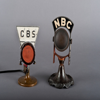

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: There are two microphones. One microphone has the letters "NBC" on it. The other microphone has the letters "CBS" on it.
==> Ground truth answer: This exhibit features a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats," a series of informal radio addresses he delivered to the American public starting on March 12, 1933. With the nation grappling with the Great Depression, Roosevelt's ability to communicate directly with citizens through radio became a vital tool for shaping public opinion and providing reassurance. The exhibit highlights an RCA Type 50-A microphone, adorned with the National Broadcasting Company logos, which was used during these broadcasts. Acquired by the

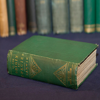

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A green book with gold lettering sits on a blue cloth.
==> Ground truth answer: This exhibit showcases "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, anniversary of the HMS Beagle's launch, the vessel that carried Darwin on his pivotal scientific journey. The Beagle was launched from the Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, joined the crew to provide geological insights, and his extensive research during the five-year expedition to South America and the Galápagos Islands laid th

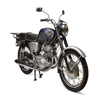

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a black color motor bike.
==> Ground truth answer: This exhibit features Robert M. Pirsig's iconic 1966 Honda Super Hawk motorcycle, prominently showcased at the Smithsonian's National Museum of American History. This motorcycle is not just a vehicle; it is a symbol of the philosophical journey outlined in Pirsig's influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book quickly became a bestseller, selling over a million copies within its first year and igniting a cultural movement that encouraged individuals to reevaluate their relationship with technology and seek a harmonious existence. The inspiration for "Zen" arose from a tran

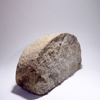

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a rock.
==> Ground truth answer: The exhibit features the Plymouth Rock Piece, a significant artifact housed at the National Museum of American History, which is believed to be linked to the landing of the Mayflower Pilgrims in 1620. According to tradition, this rock marks the site where William Bradford and his fellow settlers first arrived in Plymouth, Massachusetts. Bradford, who played a pivotal role as a leader and governor of the Plymouth Colony, is also credited with the establishment of Thanksgiving as it is celebrated in the United States today. The rock has a storied past, having been relocated in 1774 from its original position to the town square, where it unfortunately split into two halves.

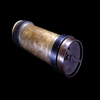

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a cylindrical object.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a Pneumatic Mail Container from 1953, a fascinating relic of a bygone era when cities utilized pneumatic tube systems for mail delivery. Originating in the late 1890s, these systems were ingeniously designed to transport mail through underground tubes, with each canister capable of holding up to 500 letters. The canisters, or carriers, were propelled by compressed air, allowing them to travel at speeds averaging 35 miles per hour. At the height of their operation, these systems facilitated the movement of an astounding 6 million pieces of mail daily, with five carriers dispatched every minut

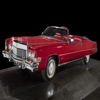

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a car in red color.
==> Ground truth answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture showcases a remarkable piece of musical history: Chuck Berry's striking red 1973 Cadillac Eldorado. This vehicle is prominently featured in the museum's "Musical Crossroads" exhibition. The Cadillac was a cherished part of Berry's personal collection and gained fame during the filming of the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford. The film captures the essence of two concerts held in 1986 to honor Berry's 60th birthday, and it features a memorable moment when Berry drove this very Cadillac onto the stage of the Fox T

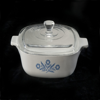

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: White pot with a blue flower design by Pyrex.
==> Ground truth answer: This exhibit features a quintessential kitchen item often associated with holiday gatherings—a white casserole dish made by CorningWare in 1965. Adorned with the iconic blue cornflower motif, this dish represents a blend of innovation and tradition. Originally created for military use during World War II, CorningWare's Pyroceram material later emerged as an ideal choice for bakeware, thanks to its ability to endure rapid temperature shifts and resist stains and odors. Its versatility allowed it to transition seamlessly from cooking to freezing to serving, making it a beloved tool in many kitchens. In the 1990s, the brand 

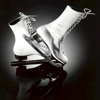

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a pair of ice skates.
==> Ground truth answer: This exhibit features the autographed ice skates of Sonja Henie, a pioneering figure in women's figure skating, dating back to around 1945. Henie, a Norwegian skater, revolutionized the sport in the late 1920s and 1930s by introducing white leather skates, a significant departure from the traditional black skates. Her enchanting performances earned her the first of ten consecutive world titles in 1927, where she captivated audiences with her innovative dance style. Henie's influence extended beyond the rink; she was the first to blend choreography with figure skating and popularized the short skirt and white skate aesthetic that remains fas

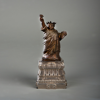

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a statue of liberty.
==> Ground truth answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Crafted in the United States, this statuette was produced in large quantities, with tens of thousands sold to raise funds for the construction of the statue's pedestal in New York Harbor. The design, created by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with a national newspaper campaign promoting them at one dollar and five dollars respectively. Richard Butler, a rubber manufacturer from New York, led the American Committee overseeing the production of these models. This ini

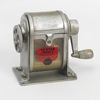

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a machine.
==> Ground truth answer: The exhibit features the Dexter Model 3 Pencil Sharpener, crafted around 1920 by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. This charming artifact, made from metal, cellulose, and painted wood, measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). A gift from Lucy Commoner, it holds a significant place in the Cooper Hewitt, Smithsonian Design Museum collection, although it is not currently on display. As the back-to-school season approaches, this sharpener evokes nostalgia for many, reminiscent of countless school days. The Dexter Model 3 was an evolution of earlier designs, featuring a rotating wheel with calibrated open

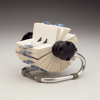

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A round item with cards on it with the number 1 on it.
==> Ground truth answer: This exhibit features the iconic Rolodex Open Rotary Card File, a quintessential office supply that revolutionized the way people organized their business contacts before the advent of digital technology. Manufactured by the Rolodex Corporation in the USA, this particular model is crafted from bent tubular metal, molded plastic, rubber, and paper, measuring 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical design, allowing users to easily flip through A-Z index cards to find contact information. Despite the rise of smartphones and computers, the Rolodex remains a relevant tool in modern workplaces, symboli

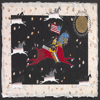

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a painting.
==> Ground truth answer: The exhibit features the "Lakota Horse Mask," created in 2008 by Jim Yellowhawk, a member of the Cheyenne River Lakota tribe. This striking piece, which utilizes acrylic on paper and gold leaf, symbolizes the profound relationship between American Indians and horses, which many tribes refer to as the Horse Nation. Horses were not only allies in times of peace but also played a vital role during conflicts, deeply influencing the cultural landscape of various tribes. Interestingly, horses first emerged in the Americas over 40 million years ago, later becoming extinct before being reintroduced by Columbus in 1493. Today, this artwork is part of the coll

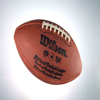

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a football.
==> Ground truth answer: This exhibit features the iconic Wilson Duke football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was specifically used during Super Bowl XIV, held at the Rose Bowl in Pasadena, California, on January 20, 1980. In this thrilling game, the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Notably, it was also the second consecutive year that quarterback Terry Bradshaw earned the Most Valuable Player award. The Wilson Duke football, known for its premium leather and durable construction, was introduced by Wilson Spo

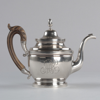

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a teapot.
==> Ground truth answer: This exhibit features a remarkable silver teapot created by American artisan Peter Bentzon, dating from approximately 1817 to 1829. The teapot showcases an elegant oval vase shape, supported by a spreading pedestal foot. Its design includes a gracefully curved spout, which is topped with an incised patera, and a scroll handle adorned with wooden leaf caps. The hinged domed lid is finished with an acorn finial, adding to its aesthetic appeal. Notably, the piece bears the scripted monogram "MC" engraved on its side, alongside the name "Rebecca Dawson" inscribed along the bottom rim. This exquisite object is part of the National Museum of African American His

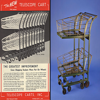

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a poster. On the left side there is a picture of a trolley. On the right side there is a picture of a trolley.
==> Ground truth answer: The exhibit at the National Museum of American History features the innovative Telescoping Shopping Cart, designed by Orla E. Watson in 1946. This clever invention, first introduced in 1947 at Floyd's Super Market in Kansas City, Missouri, revolutionized the way consumers shop by allowing carts to nest together for efficient storage. Watson asserted that these new carts utilized only one-fifth of the space of traditional carts when parked, making them a practical solution for busy shoppers. This display is part of the Smithsonian's inaugural major exhibition on food his

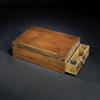

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a wooden box with two drawers.
==> Ground truth answer: This exhibit showcases the portable writing desk designed by Thomas Jefferson, which he used to draft the Declaration of Independence in 1776. The desk features a hinged writing board and a locking drawer for storing essential writing materials such as papers, pens, and an inkwell. During the summer of 1776, as members of the Second Continental Congress prepared to declare independence from Great Britain, Jefferson, a Virginia delegate, was tasked with drafting this pivotal document. He later noted that the declaration was meant to reflect the collective American sentiment rather than being an original work. On July 4, 1776, the Continental Congres

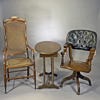

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: Three old fashioned chairs are on display.
==> Ground truth answer: This exhibit focuses on a pivotal moment in American history, specifically the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. It showcases the chair used by General Ulysses S. Grant during his negotiations with General Robert E. Lee, marking the effective conclusion of the Civil War. The exhibit highlights how Grant, seated in this chair, drafted and signed the surrender terms, a significant act that symbolized the end of hostilities. Following the surrender, Union officers took pieces of furniture as mementos, with Grant's chair and the table being notable examples. These artifacts were eventually donated to the 

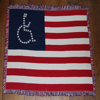

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: On the floor is a blanket with the American flag on it.
==> Ground truth answer: This exhibit features a unique lap blanket that has been hand-altered to incorporate the universal access symbol, represented by stitched stars, reflecting the ideals of freedom and independence associated with the American flag. Created by advocates from the American Disabled for Attendant Programs Today (ADAPT), this piece signifies the ongoing struggle for civil rights among individuals with disabilities. Founded in 1983 in Denver, ADAPT emerged from the disability rights movement, which gained momentum after World War II as individuals with disabilities formed communities and advocated for their rights. The lap blanket serves a

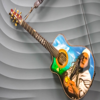

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A guitar is hung up on the wall. It is signed "Vive".
==> Ground truth answer: This exhibit showcases the guitar of Carlos Vives, a renowned Colombian singer and Grammy Award winner celebrated for his contributions to the vallenato music genre. Vallenato, originating from Colombia's Atlantic coast, blends European instruments like the accordion with rich, poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, vallenato was performed by rural workers and cowboys, remaining largely within local communities until its revitalization in the 1990s by artists like Vives, who infused it with pop and rock elements. This transformation propelled vallenato into the global spotlight, reso

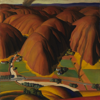

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this image we can see trees, houses, grass, road, hills and sky.
==> Ground truth answer: This exhibition features a captivating painting by Ross Dickinson, a talented artist who thrived during the Great Depression. Created while he was part of the Public Works of Art Project, the artwork vividly portrays California's Central Valley, showcasing lush green fields alongside a small river, all framed by stark, arid hills. The scene evokes the promised land sought by many families fleeing the Dust Bowl, yet Dickinson introduces an unsettling element—a small controlled fire in the foreground and a larger plume of smoke rising from the distant hills, hinting at the ever-present threat of wildfi

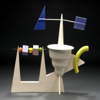

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a sculpture.
==> Ground truth answer: This exhibit features the imaginative work of artist Peter Shire, born in Los Angeles in 1947. Notably, Shire's teapots, particularly the Weathervane Teapot, are vibrant constructions made from clay slabs, showcasing a playful arrangement of three-dimensional squares, balls, squiggly rods, and hollow tubes. Shire aimed to challenge conventional notions of "tea-time," making it an experience that is inclusive and accessible to everyone. The design of this teapot invites interaction, prompting viewers to ponder how to hold it for pouring, or whether it is even functional as a teapot. After 1985, Shire shifted his focus from creating clay teapots to furniture design. A

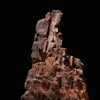

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a wooden object.
==> Ground truth answer: The exhibit features the Spotsylvania tree stump, a poignant relic from the Civil War, dating back to 1864–65, located at the Smithsonian's National Museum of American History. This tree, once a majestic oak, stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864, when it became a silent witness to the brutal conflict between Confederate forces and the Union's Second Corps. The area, now known as the Bloody Angle, transformed dramatically over the course of a single day, as the fierce combat led to approximately 31,000 casualties. The tree stump bears the scars of war, with several Minié balls still lodged within it

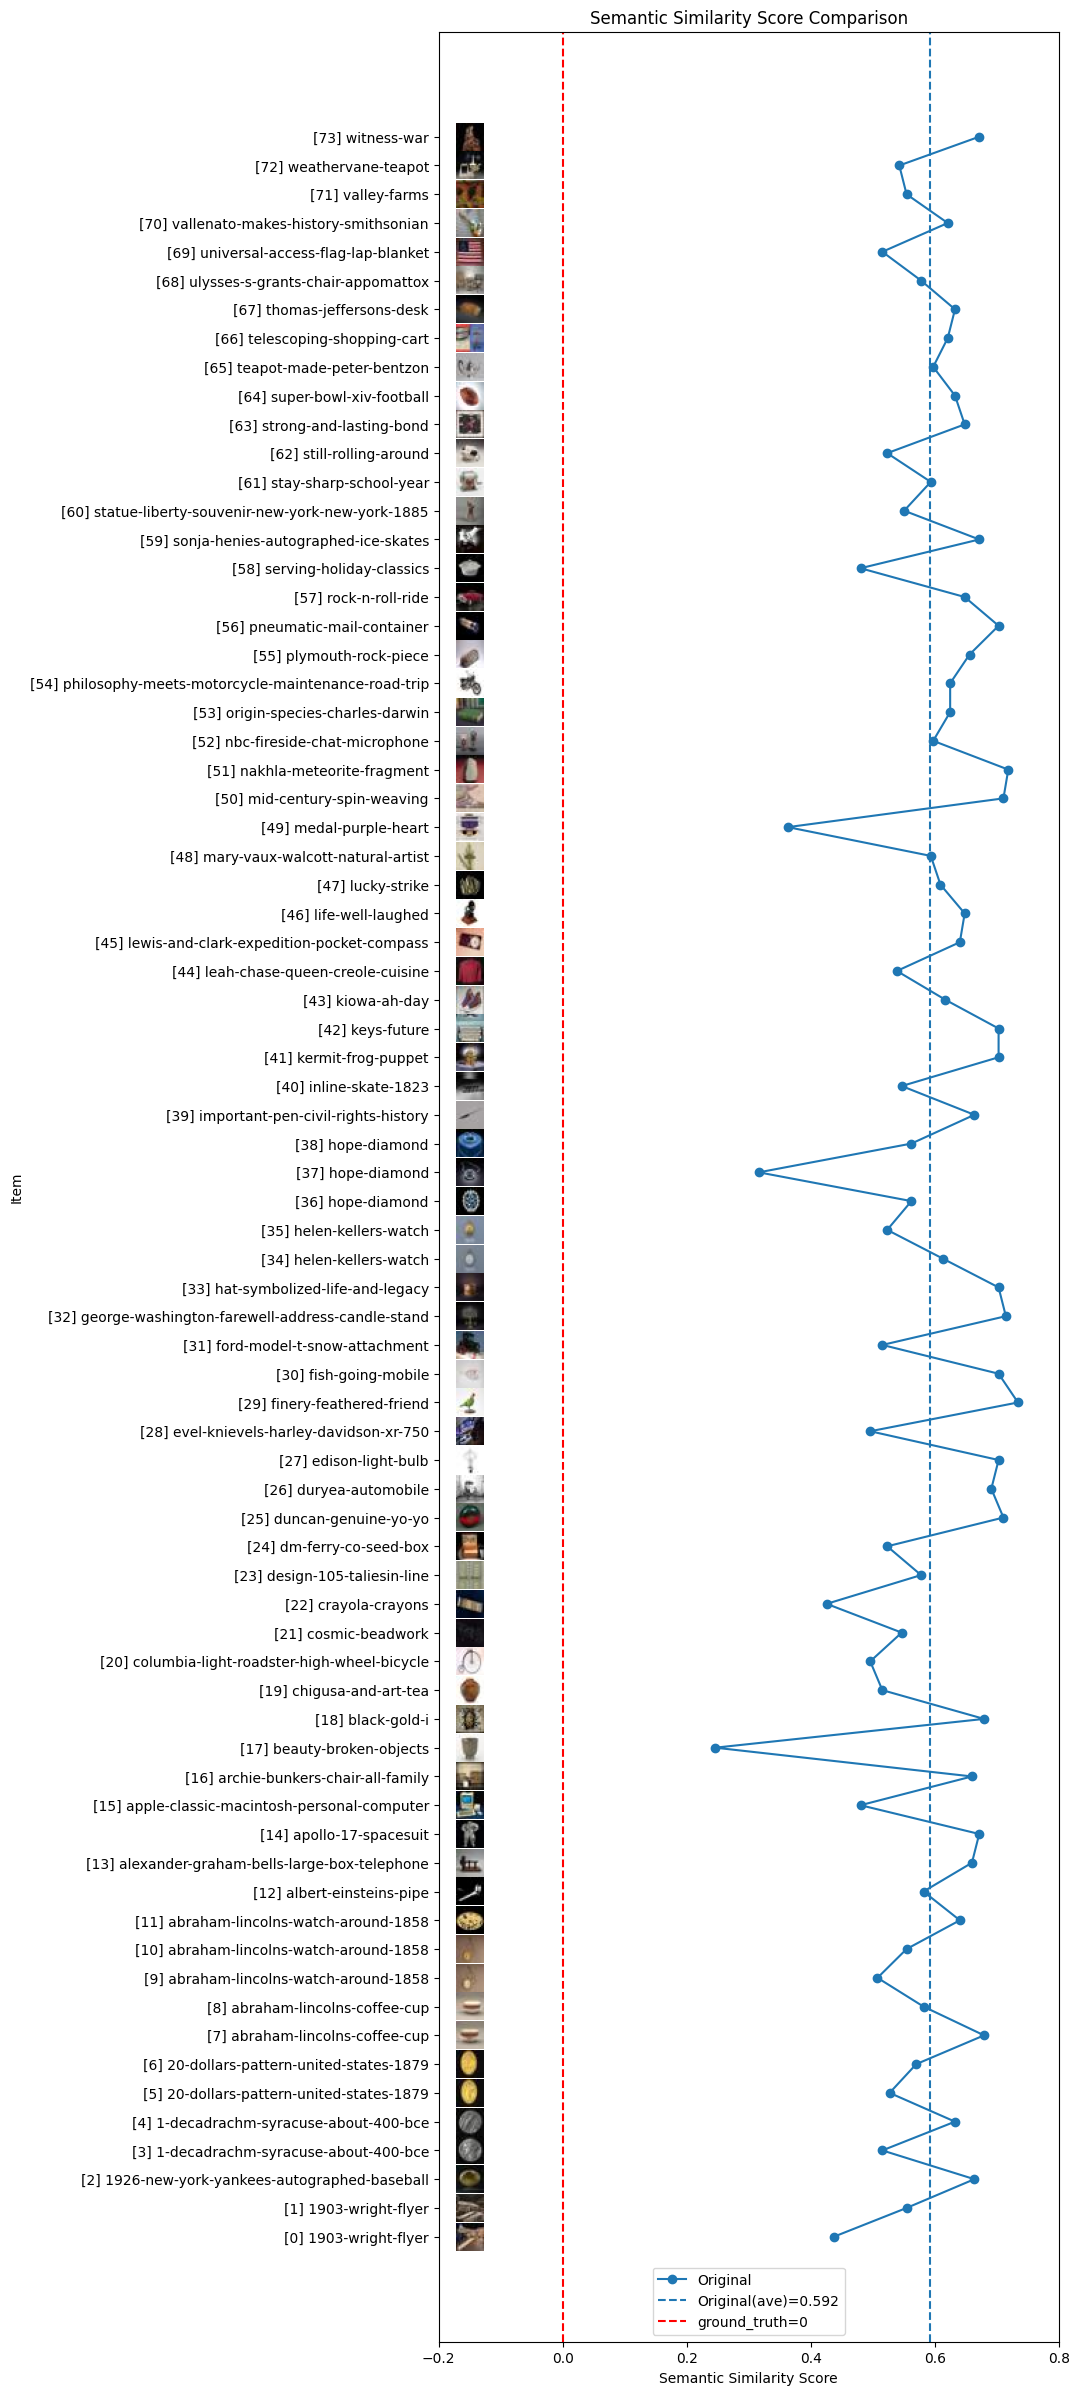

In [5]:
# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 2) 
# Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')], 
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg')

---
# **Step 3: Training**

## 3.1 Add a Custom Padding Token

In [6]:
# Set up pad token (<pad>) in the processor
my_utils.setup_pad_token_in_processor(processor)
# Set up pad token (<pad>) in the base model
my_utils.setup_pad_token_in_model(base_model, processor)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.


## 3.2 Create a LoRA Adapter

In [7]:
#create lora adapter with rank=8 and lora_alpha=64
lora_model = my_utils.create_lora_adapter(base_model, 8, 64)
my_utils.print_model_info_to_file(lora_model, './results/model_info/lora_model_info.txt')
my_utils.print_model_parameters_to_file(lora_model, './results/model_info/lora_model_parameters.txt')

==> Creating LoRA adapter...
==> Printing model info...
==> Model type: PeftModelForCausalLM
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/lora_model_info.txt.
==> Printing model parameters...
base_model.model.model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.encoder.layers.0.self_attn.k_proj.weight (663552, torch.uint8, cuda, False)
base_model.model.model.vision_model.encoder.layers.0.self_attn.k_proj.bias (1152, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.encoder.layers.0.self_attn.v_proj.weight (663552, torch.uint8, cuda, False)
base_m

## 3.3 Set Up the Trainer

In [8]:
custom_callback = my_utils.CustomCallback()  # Optional: Custom callback to report VRAM usage during the first training step
trainer = my_utils.setup_trainer(lora_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=2, callbacks=[custom_callback])

Using auto half precision backend


==> Setting up trainer...


## 3.4 Train the Model

In [9]:
my_utils.run_training(lora_model, trainer)

Currently training with a batch size of: 2


==> Starting training...


***** Running training *****
  Num examples = 819
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 1,230
  Number of trainable parameters = 23,326,720
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


[GPU0] Step 1: Current VRAM usage: 4.72 GB, Peak VRAM usage: 11.85 GB, Total GPU VRAM: 15.72 GB



***** Running Evaluation *****
  Num examples = 82
  Batch size = 2
Saving model checkpoint to ./results/training_checkpoints/checkpoint-62
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]

***** Running Evaluation *****
  Num examples = 82
  Batch size = 2
Saving model checkpoint to ./results/training_checkpoints/checkpoint-124
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoin

---
# **Step 4: Post-Training**

## 4.1 Restart Kernel for a Clean Environment

## 4.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. This fine-tuned model will be used for further inference to assess improvements in model performance.


In [1]:
# Load functions
import my_login
import my_utils
import my_utils_qlora

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
bnb_config = my_utils_qlora.create_quantization_config()
base_model = my_utils.load_model(quantization_config=bnb_config)

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load LoRA adapter from a checkpoint with the minimum loss
lora_model = my_utils.load_lora_adapter_from_checkpoint(base_model, './results/training_checkpoints/checkpoint-1178')


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


==> Loading processor...


Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Creating Quantization Configuration...
==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Loading LoRA adapter from checkpoint...


## 4.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/37] Data in batch: 2
==> [Batch: 1/37][Data: 1/2] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


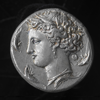

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases the Syracuse dekadrachm, an exquisite coin from the late 5th century BCE, renowned for its intricate artistry and high relief, crafted by celebrated artists such as Kimon and Euinatos. The coin's captivating beauty has intrigued collectors for over two millennia. Notably, Theodore Roosevelt recognized the need for American coinage to embody similar artistic values, leading him to commission sculptor Augustus Saint-Gaudens to create the iconic 1907 twenty-dollar gold piece. While the dekadrachm is currently not on view, it remains an important part of the National Numismatic Collection, reflecting the rich history of coinage and its artistic significance.
==> Ground truth answer: The exhib

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


==> [Batch: 1/37][Data: 2/2] Inference for data_id: 4, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-2.jpg:


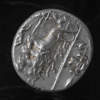

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases the Syracuse dekadrachm, a remarkable coin from the late 5th century BCE, renowned for its intricate artistry and high relief, crafted by celebrated artists such as Kimon and Euinatos. The coin's design features a striking horse, a central element of Greek coinage, and is notable for its use of a novel inscription, which reads "IN GOD WE TRUST." This inscription reflects the religious beliefs of the time and serves as a testament to the cultural significance of coins in ancient Greece. The dekadrachm is part of the National Numismatic Collection at the National Museum of American History, although it is currently not on display.
==> Ground truth answer: This exhibit hi

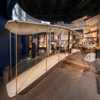

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, an iconic aircraft that symbolizes the beginning of human flight. Crafted by Wilbur and Orville Wright, this biplane is powered by a 12-horsepower engine and utilizes a sprocket-and-chain system to turn its pusher propellers. Notably, the Flyer employs non-wheeled skids for landing and retains a natural fabric finish without any paint or sealant. The Wright brothers' groundbreaking work during four years of research not only led to this remarkable flight but also established key principles of modern aeronautical engineering, including the use of wind tunnels in design experimentation. After its historic first flight on December 17, 1903, the Flyer was damaged but has

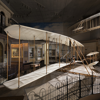

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, the first successful powered aircraft to achieve controlled flight. Crafted by Wilbur and Orville Wright, this biplane is powered by a 12-horsepower engine and utilizes a sprocket-and-chain system to drive its pusher propellers. Notably, the Flyer employs skids for landing and lacks traditional wheels. The Wright brothers' groundbreaking work during four years of research not only led to this remarkable flight but also established key principles of modern aeronautical engineering, including the use of wind tunnels in design experimentation. The Flyer is part of the National Air and Space Museum collection and was restored in 1948, showcasing the r

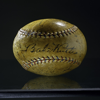

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the 1926 New York Yankees, signed by Babe Ruth, one of baseball's most famous hitters. Ruth, who played a remarkable 2,130 consecutive games for the Yankees, is celebrated for his extraordinary batting skills and leadership during the team's 22-year reign. The ball, made from cork, wool, and horsehide, measures 3 inches in diameter and is currently not on display. It was generously donated by the Elliot Spencer family through Brad Spencer and is cataloged under number 2002.0123.01 in the museum's collection, which encompasses 137 million artifacts.
==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York 

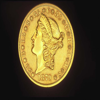

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases a remarkable gold coin from the United States Mint in Philadelphia, dating back to 1879, under the reference number Judd 1643. The coin features a Liberty head on the obverse, with the date and weight inscribed around it. On the reverse, an eagle is depicted, but it bears the Latin motto DEO EST GLORIA instead of the usual IN GOD WE TRUST. This design was part of an initiative aimed at enhancing the competitiveness of American coinage in global markets, paralleling the creation of the four-dollar gold Stella coin. Only nine of these gold pieces are known to exist, including this one, which is housed in the National Numismatic Collection at the National Museum of American History. Although

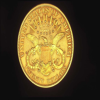

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases a remarkable gold coin from the United States Mint in Philadelphia, dating back to 1879, known as the Stella coin. The obverse features a Liberty head, with the date and weight inscribed around it. The reverse is adorned with an eagle, similar to that found on the standard twenty-dollar coin, but with the Latin motto DEO EST GLORIA replacing the usual IN GOD WE TRUST. This design was part of an initiative aimed at enhancing the competitiveness of American coinage in global markets, paralleling the creation of the four-dollar gold Stella coin. Only nine of these gold pieces are known to exist, including the one on display. Although this particular coin is not currently 

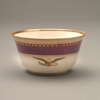

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, a poignant artifact from 1887, housed at the Smithsonian's National Museum of American History. Known for his towering height of 6'4”, Lincoln was also recognized for his distinctive appearance, often accentuated by his favorite coffee cup. Although he was not one to show off, this ceramic cup, adorned with a striking purple color and featuring a gold trim, was a cherished possession of the President. The cup's story intertwines with a pivotal moment in American history—April 14, 1865, the night of Lincoln's assassination. Just before heading to Ford's Theatre, President Lincoln inadvertently left this cup on a windowsill, where it was later preserved by a Whi

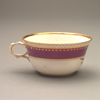

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, a significant artifact from 1887, housed at the Smithsonian's National Museum of American History. Known for his towering height of 6'4”, Lincoln was also recognized for his distinctive appearance, often accentuated by his favorite coffee cup. Although he was not one to show off, this particular cup, crafted from ceramic and adorned with purple and gold trim, was gifted to the Smithsonian by Lincoln Isham, the great-grandson of Abraham Lincoln. The cup's story intertwines with a pivotal moment in American history—April 14, 1865, the day of Lincoln's assassination. Just before heading to Ford's Theatre, President Lincoln inadvertently left t

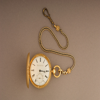

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this exquisite watch served as a symbol of his success in his legal career. The watch's movement was manufactured in Liverpool, a renowned watchmaking city, while the case was crafted by an unidentified American maker. The watch's movement is known for its exceptional quality, capable of accurate timekeeping within seconds daily, and is enclosed in a beautiful 18K gold case. A remarkable story accompanies this watch; during repairs on April 12, 1861, watchmaker Jonathan Dillon engraved a hidden message insid

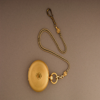

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this exquisite watch served as a symbol of his success in his legal career. The watch's movement was manufactured in Liverpool, a renowned watchmaking city, while the case was crafted by an unidentified American maker. The watch's movement is known for its exceptional quality, capable of accurate timekeeping within seconds daily, and is enclosed in a beautiful 18K gold case. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 

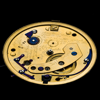

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this exquisite watch served as a notable symbol of his success in law. The watch's movement, crafted in Liverpool by a prominent watchmaking industry, was paired with a case made in an unidentified American workshop, showcasing the high-quality standards of the time. A remarkable story accompanies this watch; during repairs on April 12, 1861, watchmaker Jonathan Dillon engraved a message inside the watch, commemorating the Confederate attack on Fort Sumter. An

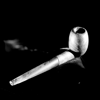

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary artifact: Albert Einstein's pipe, dating back to around 1948. Einstein, a legendary figure in theoretical physics and a Nobel Prize laureate, is also recognized for his distinctive appearance, often characterized by his beloved pipe. Although he reduced his smoking later in life due to health concerns, he cherished the experience of holding a pipe. This particular pipe shows signs of wear, indicating its frequent use, and was gifted to Gina Plunguian, a devoted friend of Einstein. The Smithsonian acquired this significant piece in 1979. It is part of a larger collection of over 1,000 artifacts displayed at various Smithsonian Affiliates, contributing to the 137 million ite

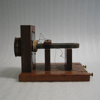

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History highlights the revolutionary invention of the telephone by Alexander Graham Bell. He received the first patent for this device on March 7, 1876, and just three days later, he made the first successful communication with his assistant, Thomas Watson, who famously heard the words, “Mr. Watson, come here, I want to see you.” Among the items on display is one of the telephones used during a demonstration between Boston and Salem on November 26, 1876. This particular telephone features an iron diaphragm and two electromagnets, distinguishing it from other models in the Smithsonian's collection that typically have wooden covers. Acquired in 1923 from the America

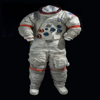

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic piece of history from the final Apollo mission that landed astronauts on the moon in December 1972. The mission was launched on December 7, 1972, using the powerful Saturn V rocket and included a notable crew: Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, the only geologist to have walked on the moon. While Evans remained in lunar orbit, Cernan and Schmitt successfully landed the lunar module "Challenger" in the Taurus-Littrow region and spent three days conducting scientific explorations, including three moonwalks. They collected a record 110 kilograms of lunar samples and drove a lunar rover for 35 kil

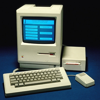

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases the Apple "Classic" Macintosh Personal Computer, which made its debut in January 1984. Apple Inc. introduced a revolutionary graphic user interface that allowed users to interact with their computers through icons rather than traditional command lines. This innovation was inspired by concepts from Xerox's Palo Alto Research Center but was successfully commercialized by Apple, which famously promoted the Macintosh with a Super Bowl XVIII advertisement, pricing it around $2,500. The original model featured a mere 128K of RAM, prompting the release of the Macintosh 512 KB, affectionately called "Fat Mac," just months later. This upgraded model offered four times the memory, facilitating the 

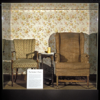

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an upholstered wing chair that was used by the character Archie Bunker, played by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, characterized by its orange-yellow woven fabric and wooden frame, likely dates back to the 1940s, although its exact origins are not documented. It was procured from a thrift store in Southern California and became a key prop in the series, which aired from 1971 to 1979, until it was replaced by a replica in the final season after being donated to the Smithsonian. "All in the Family," created by Norman Lear and Bud Yorkin, was a revolutionary sitcom that tackled complex social and political issues, a stark contrast to th

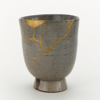

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable tea bowl from the 17th century, belonging to the White Satsuma type from Kagoshima prefecture, Japan, dating back to the Edo period. The bowl is notable for its clear, crackled glaze and has a unique history marked by a breakage that led to its restoration through the Japanese technique of kintsugi, or golden repairs. Unlike conventional restoration methods that aim to hide damage, kintsugi embraces it, highlighting the bowl's past. The repairs are adorned with lacquer, a natural resin derived from tree sap, which is known for its durability and water-resistant properties. Once cured, the lacquer becomes a strong and water-resistant adhesive, making it an effective medium for 

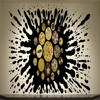

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. It includes a striking arrangement of 25 circular canvases, each varying in size, placed over a large-scale ink splatter pattern that has been meticulously created with a template. The canvases are adorned with foliate motifs painted in black and gold, utilizing Dutch wax printed fabrics, which is a hallmark of Shonibare's work. The splatter effect, applied using a template, creates a dynamic visual impact that challenges conventional edges and borders. This piece reflects the artist's exploration of identity and cultural heritage, inviting viewers to reflect on deeper meanings within the context of Dutch h

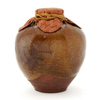

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibition titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of object collection. At its heart is the tea-leaf storage jar known as Chigusa, which exemplifies how Japanese collectors infused meaning into everyday items through the practices of naming and adornment. This jar, originally a simple Chinese import, was transformed into a revered object through the rituals of chanoyu, or tea ceremony, as documented in 16th-century tea diaries. These historical accounts provide a glimpse into the admiration and reverence that tea participants had for Chigusa, detailing how it was elegantly dressed in ornam

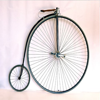

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History highlights the arrival of spring with an original 1886 Columbia Light Roadster high-wheel bicycle. Manufactured by the Pope Manufacturing Co., the first bicycle company in the United States, this bicycle is crafted with a 53-inch front wheel featuring 60 spokes and an 18-inch rear wheel with 20 spokes. Accompanying this display is a historic photograph of one of the first organized cycling tours in America, featuring Charles E. Pratt, the first president of the League of American Wheelmen, captured in 1879 outside Readville, Massachusetts. The Smithsonian's cycling collection, established in 1889, consists of 60 bicycles that reflect the technological adva

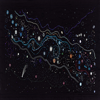

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features "Milky Way, Starry Night #2," a striking work by Gwich'in artist Margaret Nazon from Tsiigehtchic, Northwest Territories, Canada, created in 2021. Nazon's artistic journey began later in life, inspired by her childhood fascination with the night sky. This piece showcases swirling galaxies, a novel theme in Gwich'in beadwork, reflecting her unique artistic evolution. It is part of the "Lights Out: Recovering Our Night Sky" exhibition at the Smithsonian's National Museum of Natural History, which highlights the significance of the night sky and its decline in visibility due to light pollution. This thought-provoking exhibition will run until December 2025, and Nazon's work will be incorporate

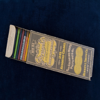

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a historic pack of Crayola Crayons from 1903, celebrating the beloved American art form created by the Binney & Smith Company in Easton, Pennsylvania. These crayons were crafted using paraffin wax and non-toxic pigments, making them safe and sturdy for children. The name "Crayola," attributed to Alice Binney, cleverly combines the French word for chalk, "craie," with "oleaginous," referring to their waxy texture. This particular set, intended for "young artists," is one of the earliest editions available and includes 28 colors such as celestial blue, golden ochre, rose pink, and burnt sienna. The box, marked "No. 51, Young Artists Drawing Crayons," originally housed 28 crayons but now cont

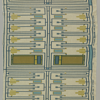

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking textile designed by the renowned Frank Lloyd Wright, an American visionary who lived from 1867 to 1959. Manufactured by F. Schumacher & Co., a prominent New York-based textile manufacturer established in 1889, this printed linen showcases a geometric pattern composed of rectangular blocks in soothing shades of light blue and olive, interspersed with fine lines of darker blue on an off-white background. The dimensions of this screen-printed linen are 120 cm in height and 57.5 cm in width, with a repeat height of 63.5 cm. Additionally, five alternative colorways are attached to the upper back of the textile. This piece was a gift from Mr. and Mrs. Burton Tremaine in 1956 and is cu

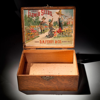

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, showcasing a piece of history from D.M. Ferry & Co., as part of the Smithsonian's celebration of National Garden Month. In the 19th century, seed packets were typically arranged in wooden boxes adorned with eye-catching labels, serving as effective marketing tools on store counters. This particular seed box is notable for its association with D.M. Ferry & Co., which pioneered the "commission box" concept, allowing for easy retail display. Acquired by the Smithsonian in 1986, it serves as a testament to the advertising strategies of the time. Seed companies also distributed catalogs to amateur gardeners each winter to prepare them for spring planting, wit

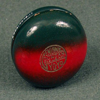

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Museum of American History features a captivating story about the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. The journey began in 1928 when Duncan discovered the yo-yo being marketed by Pedro Flores, a Filipino immigrant who had begun to manufacture wooden yo-yos. Flores had already begun selling the toy in San Francisco, where it was being marketed as a novelty, and by 1929, he had launched his own company. Duncan, recognizing the toy's potential, invested $5,000 to acquire rights from Flores and founded Donald F. Duncan Inc. He eventually acquired the entire trademark by 1932, making him the leading produ

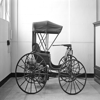

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1893-94 Duryea Automobile, an iconic representation of early American automotive innovation. Frank Duryea conducted a historic road test of this vehicle, a second-hand carriage outfitted with a gasoline engine, on September 21, 1893, in Springfield, Massachusetts. The Duryea Motor Wagon Company, founded in 1896 by Frank, his brother Charles, and their investors, was the first company to produce and sell automobiles in America. The vehicle's design includes a one-cylinder, four-cycle, four-horsepower water-cooled gasoline engine, positioned nearly horizontally beneath the body, along with a gear transmission, which replaced the original friction transmission, and a spray carburetor. Acq

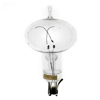

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb from 1879, a significant artifact in the history of technology. This carbon-filament bulb was used during Thomas Edison's first public demonstration of the electric incandescent lamp, which revolutionized artificial lighting. The bulb operates by allowing an electrical current to flow through a metal filament, causing it to heat and illuminate. To protect the filament from air, it is enclosed in a glass bulb filled with inert gas. This landmark demonstration took place at Edison's Menlo Park laboratory on New Year's Eve in 1879. Edison is celebrated as a quintessential American inventor and entrepreneur, holding a remarkable 1,093 patents. His journey was not without 

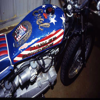

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Evel Knievel's 1972 Harley-Davidson XR-750, a motorcycle that symbolizes the daredevil's extraordinary career. Evel Knievel, born Robert Craig Knievel, became a national sensation in the 1960s and 70s, known for his thrilling stunts that often resulted in serious injuries, including 35 to 40 broken bones. His performances, which included motorcycle jumps over rows of cars, trucks, and buses, captivated audiences across the nation. The XR-750, weighing about 300 pounds and made of steel, aluminum, and fiberglass, was instrumental in his stunts, including the famous jump over 14 Greyhound buses. This exhibit not only showcases the motorcycle but also celebrates Knievel's legacy as a performe

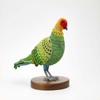

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features Laurel Roth Hope's intriguing artwork titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and currently on display at the Smithsonian American Art Museum. This piece employs humor to address the serious theme of species extinction, allowing common rock pigeons to don suits that enable them to mimic extinct North American birds. While it doesn't genuinely reclaim biodiversity, it certainly invites reflection on the concept. Hope's artistic process involves traditional methods such as carving, embroidery, crochet, and collage, resulting in intricate sculptures that are both whimsical and thought-provoking. Her background as a park ranger shapes her artistic perspective,

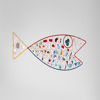

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Fish," a striking sculpture by Alexander Calder, created in 1945 and currently part of the Hirshhorn Museum and Sculpture Garden's collection in Washington, D.C. Calder, who came from a family of artists, initially pursued mechanical engineering before embracing art. His artistic journey took him to Paris, where he was influenced by avant-garde artists and began to create wire sculptures that critics described as “drawings in space.” In 1931, inspired by the simplicity of Piet Mondrian's studio, he invented the “mobile,” a type of kinetic sculpture. He also produced “stabiles,” which are static sculptures, and standing mobiles that combine both dynamic and static elements. His work evolve

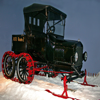

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Postal Museum features a 1921 Ford Model T outfitted with a snow attachment, illustrating the ingenuity of rural mail carriers in the early 20th century. As these carriers transitioned from horse-drawn sleds to automobiles, they soon realized that navigating snowy terrains posed significant challenges. To address this issue, Virgil White pioneered modifications in 1906, converting cars into snowmobiles by replacing front tires with skis and rear tires with caterpillar treads. This innovation allowed for easier movement over snow and reduced reliance on horses and sleds during winter deliveries. The Ford Model T, which became a symbol of early automotive culture, was pa

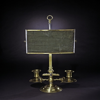

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact from American history: a brass candle stand associated with George Washington, which he used while crafting his Farewell Address in September 1796. After serving as president for two terms, Washington chose to retire rather than run for a third, emphasizing the importance of national unity in his address published in The American Daily Advertiser. This address was pivotal in shaping the nation's values and has been read in the Senate every year since 1896 in celebration of Washington's birthday. The candle stand, characterized by its adjustable reflector that amplifies candlelight, is believed to have been used by Washington during this critical moment. It was passed

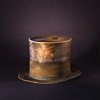

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the top hat of President Abraham Lincoln, prominently displayed at the Smithsonian's National Museum of American History. Standing at 6'4”, Lincoln was known for his distinctive high top hats, and this particular hat was crafted by Washington hat maker J.Y. Davis. The hat's specific history is somewhat elusive, but it is known that Lincoln last wore it on April 14, 1865, the night of his assassination at Ford's Theatre. Following the event, the War Department preserved the hat along with other items, and with Mary Lincoln's consent, it was transferred to the Smithsonian in 1867. Initially, the hat was kept out of public sight due to the sensitivity of its history, only being displayed for 

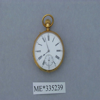

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to the renowned Helen Keller, who was born on June 27, 1880. Keller's life story is an inspiring narrative of resilience; after losing her sight and hearing as a toddler, she learned to communicate through the dedicated efforts of her teacher, Anne Sullivan. Keller went on to achieve remarkable success, including graduating from Radcliffe College in 1904, making history as the first deaf-blind person to do so. The watch, a gift from John Hitz, was specifically designed to enable the wearer to discern the time through tactile pins, a thoughtful adaptation for someone like Keller. This cherished possession symbolized her independence and resilience, an

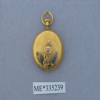

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold pocket watch that belonged to Helen Keller, dating back to the late 1800s. Celebrating Keller's birth on June 27, 1880, this exhibit highlights her extraordinary life as a deaf-blind individual who became a prominent advocate for women's rights and disability advocacy. After losing her senses at a young age, Keller learned to communicate through the dedicated efforts of her teacher, Anne Sullivan. She went on to achieve remarkable success, including graduating from Radcliffe College in 1904, making history as the first deaf-blind person to do so. The watch, a gift from John Hitz, was specifically designed to allow time to be discerned through tactile p

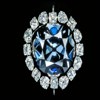

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing an impressive 45.52 carats. The diamond's captivating dark gray-blue color and its modified antique cushion cut contribute to its unique visual appeal. This exquisite piece was sourced from India, highlighting its geographical significance, and is recorded under the USNM Number NMNH G3551-00. It represents a pivotal moment in jewelry history, as it exemplifies the intersection of art and science. The necklace's design not only reflects the beauty of the gem itself but also the artistry of its creator, Cartier, Inc.
==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cart

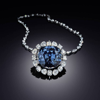

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable diamond necklace by Cartier, Inc., showcasing a single primary gem weighing an impressive 45.52 carats. The diamond's captivating dark gray-blue color and its modified antique cushion cut contribute to its unique visual appeal. This exquisite piece was sourced from India, highlighting its geological significance. It is part of the Mineral Sciences collection, specifically categorized under Gems, and bears the USNM Number NMNH G3551-00. This necklace exemplifies the luxurious craftsmanship of Cartier, renowned for its high-quality jewelry.
==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single prima

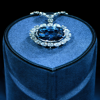

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable diamond necklace by Cartier, Inc., showcasing a single primary gem weighing an impressive 45.52 carats. The diamond's captivating dark gray-blue color and its modified antique cushion cut contribute to its unique visual appeal. This exquisite piece was sourced from India, highlighting its geographical significance. It is part of the Mineral Sciences collection, specifically categorized under Gems, and bears the USNM Number NMNH G3551-00. This necklace is a must-see for visitors interested in the artistry and geological significance of gemstones.
==> Ground truth answer: On display is a captivating diamond necklace by Cartie

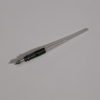

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an Esterbrook pen that holds historical significance as the instrument with which President Lyndon B. Johnson signed the Civil Rights Act of 1964 on July 2, 1964. This pen is part of the collection at the Smithsonian's National Museum of African American History and Culture, gifted by James F. Dicke, II. The Civil Rights Act was a landmark moment in American history, initially introduced by President John F. Kennedy before his assassination in November 1963. Following this, President Johnson took on the challenge of advancing the bill through Congress, which was marked by a record-setting 57-day filibuster in the Senate. The Civil Rights Act represented a foundational step toward equality,

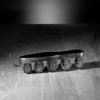

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate from 1823, attributed to Robert John Tyers. As the 2014 Winter Olympics highlight various ice sports, it's intriguing to consider how athletes of the 19th century maintained their skills without access to indoor rinks. The Volito stands out due to its unique design, which includes a wooden sole and a single row of five wooden wheels, complemented by a curved iron bar acting as a basic brake. Its innovative wheel design, with wheels that are larger in the center and smaller at the ends, allowed for enhanced turning capabilities, making it superior to other models of its time. This historical artifact is part of the National Museum of American History's collection

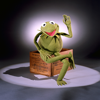

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a quintessential puppet created by Jim Henson, who has been a central figure on The Muppet Show and a beloved character on Sesame Street. Kermit first made his debut in 1955 on the television show "Sam and Friends." Over the years, he has been brought to life by various performers, including Jim Henson and Steve Whitmire, and is now voiced by Matt Vogel. Kermit's character is known for his calm demeanor amidst the chaos surrounding him, famously singing the song “Bein' Green,” which reflects on his experiences and acceptance of his identity. The puppet is constructed from a variety of materials, including synthetic fiber and felt, and measures 27 inches in height. This pie

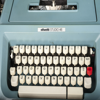

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases the typewriter that belonged to Octavia Butler (1947–2006), a groundbreaking figure in science fiction literature. Butler is celebrated for her influential works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the influential novels Parable of the Sower and Parable of the Talents, as well as the short story collection Bloodchild and Other Stories. Her writing is notable for its unique fusion of African American history and speculative fiction, a style that has come to be recognized as Afrofuturism. By centering characters from the African diaspora in her early novels like Wild Seed and Kindred, she inspired a gener

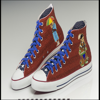

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating work titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The piece is a pair of sneakers, crafted from cotton canvas and commercial rubber, adorned with intricate overlay beadwork that showcases Kiowa artistry. Measuring 33 x 11 x 15 cm, this piece was purchased by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico. It exemplifies the fusion of traditional Native American culture with modern footwear design, making it a significant addition to the museum's collection.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, wh

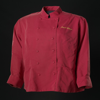

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a notable collection from the Smithsonian's National Museum of African American History and Culture, generously gifted by Dooky Chase's Restaurant and the esteemed Chef Leah Chase. Known as “The Queen of Creole Cuisine,” Chase is celebrated for her significant contributions to New Orleans Creole cooking and civil rights activism. She famously stated that “we changed the world over a bowl of gumbo,” reflecting the restaurant's role as a gathering place for civil rights discussions. Together with her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop into a fine-dining venue adorned with white tablecloths and African American art. The exhibit highlights Cha

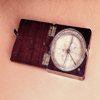

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating pocket compass that dates back to approximately 1804, originally purchased by Meriwether Lewis for the Lewis and Clark Expedition. Crafted by Thomas Whitney in Philadelphia, the compass is notable for its silver-plated brass rim, which is graduated in degrees, a paper dial, and two brass sight vanes, all securely enclosed in a mahogany box with a leather carrying case. The purpose of this compass—whether it was intended for Lewis himself or as a gift for William Clark—remains a matter of speculation. As part of the expedition commissioned by President Thomas Jefferson, Lewis and Clark embarked on their journey up the Missouri River in 1804 to explore uncharted territories and

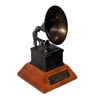

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1960 Grammy Award won by the legendary Bob Newhart, an iconic comedian and actor known for his deadpan humor that critiques societal norms. Born on September 5, 1929, in Oak Park, Illinois, Newhart has had a profound impact on the comedy landscape over his remarkable sixty-year career. His debut album, The Button-Down Mind of Bob Newhart, made history as the first comedy LP to reach No. 1 on the Billboard charts and earned him two Grammys, including Album of the Year, marking him as the only comedian to win the Best New Artist Grammy. Newhart's television career includes starring roles in iconic sitcoms like The Bob Newhart Show and Newhart, which have left a lasting impact on the genr

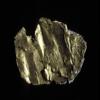

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold nugget from 1848, housed at the Smithsonian's National Museum of American History. This nugget is recognized as the first piece of gold discovered at Sutter's Mill in California, an event that catalyzed the gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall discovered a shiny object in the water and, upon examination, identified it as a scale of pure gold. This discovery was later presented to Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold found in Northern California. By August 1848, this nugget and other samples were sent to Washington, D.C., where President James K. Polk publicly an

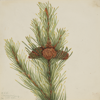

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning watercolor by Mary Vaux Walcott, titled "Lodgepole Pine (Pinus Contorta murrayana)," created in 1921 and measuring 10 x 7 inches. Walcott's journey into botanical illustration began when a botanist requested her to paint a rare arnica flower. After marrying Charles Doolittle Walcott, the Secretary of the Smithsonian, in 1914, they spent summers in the Canadian Rockies, where she produced hundreds of watercolor studies of local flora. Her work culminated in the publication of 400 illustrations in the five-volume series "North American Wild Flowers" between 1925 and 1929, followed by her illustrations for "North American Pitcher Plants" in 1935. Walcott's contributions were instru

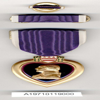

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed United States Purple Heart, a heart-shaped medal that symbolizes military bravery. The medal is elegantly designed in a gold heart shape, showcasing a profile relief of George Washington against a striking purple enamel background. Above the bust, a shield depicts Washington's family coat of arms. The reverse side bears the inscription "FOR MILITARY MERIT," honoring those who have displayed exemplary service. The medal is suspended from a silk ribbon that is purple with a white edge stripe. With dimensions of 3.7 cm by 1.1 cm by 8.1 cm (approximately 1 7/16 by 7/16 by 3 3/16 inches), it is composed of copper alloy, silk, gold plating, and a non-magnetic white metal alloy. This

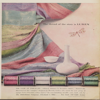

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit titled "The Thread of the Story Is Lurex: The Look of Porcelain" features an advertisement from approximately 1953, showcasing the work of renowned American textile designer Dorothy Liebes (1897–1972). Liebes is celebrated for her significant contributions to various design fields, including interior design, fashion, and film, where she collaborated with notable figures like Frank Lloyd Wright and fashion luminaries such as Adrian. Her fabrics, characterized by vibrant colors and a metallic luster, became synonymous with mid-20th-century American modernism. Despite her recognition during her lifetime, the full extent of her impact on 20th-century design is often overlooked. The advertisement is part

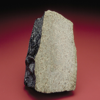

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a fragment of the Nakhla meteorite, an extraordinary specimen among the thirty-four meteorites known to have come from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, in the Nakhla region of Alexandria, Egypt, where it was observed exploding in the atmosphere before breaking apart into approximately 40 pieces, collectively weighing 22 pounds. Many of these fragments were buried up to a meter deep in the ground. The Smithsonian received two samples shortly after the fall, and in 1962, a notable 480-gram piece was added, bringing the total collection to 650 grams by the 1970s. Nakhlites, the term for these Martian meteorites, are igneous rocks rich in augite, formed from basaltic 

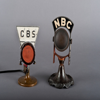

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a significant artifact from President Franklin D. Roosevelt's "Fireside Chats," which began on March 12, 1933. These informal radio addresses were a response to the dire circumstances of the Great Depression, during which Roosevelt sought to connect with the American people directly. The first chat took place in the Lincoln Study, while later ones occurred in the Diplomatic Reception Room of the White House. The microphone on display, adorned with the National Broadcasting Company logos, was preserved by Carleton Smith, who was responsible for its setup. Acquired by the museum in 1996, this artifact not only represents a pivotal moment in presidential communica

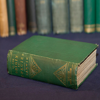

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the groundbreaking book "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, launch of the HMS Beagle from Woolwich Dockyard in London, which played a crucial role in Darwin's scientific exploration. The Beagle embarked on its second survey voyage on December 27, 1831, with Darwin on board as a naturalist. Over the course of five years, the expedition to South America and the Galápagos Islands allowed Darwin to gather extensive data, including fossils and plant specimens, which informed his revolutionary theory of evolution by natural selection. The publication of "On the Origin o

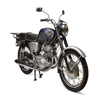

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a significant artifact from his acclaimed book, Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values, published in 1974. The book achieved remarkable success, selling over a million copies in its first year and initiating a global movement that encouraged individuals to reflect on their relationship with technology and seek a more harmonious way of living. Pirsig's inspiration came from a transformative month-long motorcycle journey he undertook with his son Chris in 1968, covering 5,700 miles from Minnesota to San Francisco. This journey not only deepened their bond but also served as a backdrop for exploring the connection

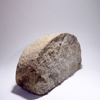

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece from 1620, located at the National Museum of American History. It is one of the earliest artifacts associated with the Pilgrims' landing in Plymouth, Massachusetts. The rock is traditionally recognized as the landing site of the Mayflower Pilgrims, led by William Bradford, who became the first governor of Plymouth Colony. Bradford is also recognized for his role in establishing Thanksgiving as a national holiday in the United States. The rock has a storied history; in 1774, it was moved from its original shoreline location to the town square, where it split into two halves. The lower half remained in place, while the upper half was relocated to a meeting house. In 1

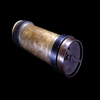

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, housed at the Smithsonian's National Postal Museum. In the late 1800s, cities began implementing pneumatic tube systems to transport mail efficiently beneath their streets. Each canister, or carrier, could hold up to 500 letters and was propelled through the tubes by compressed air, reaching speeds of approximately 35 miles per hour in a spinning motion. At the height of its functionality, the pneumatic system moved an impressive six million pieces of mail daily, with five carriers dispatched every minute. The first pneumatic tube service began in Philadelphia in 1893, followed by New York City in 1897, and later expanded to cities like Boston, Chica

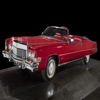

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture features a striking 1973 red convertible Eldorado Cadillac, famously owned by Chuck Berry. This exhibit is part of the broader "Musical Crossroads" exhibition, which explores the rich tapestry of music and its cultural impact. The Cadillac is particularly significant as it was featured in the 1987 documentary "Hail! Hail! Rock 'n' Roll," which celebrates Berry's life and music during two concerts for his 60th birthday. A memorable moment in the film occurs when Berry drives this Cadillac onto the stage of the Fox Theater in St. Louis, a venue that had previously denied him entry as a child due to racial

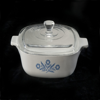

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a classic white casserole dish from CorningWare, dating back to 1965, adorned with the brand's distinctive blue cornflower design. This dish is part of a collection that highlights the evolution of kitchenware, as it illustrates the use of Pyroceram—a revolutionary glass-ceramic material created during World War II for military needs. After the war, its excellent thermal resistance and ability to resist stains and odors made it a popular choice for home cooks. This versatile cookware could be employed for cooking, freezing, and serving, streamlining kitchen tasks. In the 1990s, CorningWare shifted towards ceramic stoneware to meet consumer demand for a broader array of 

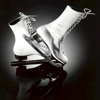

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, dating back to around 1945, located at the Smithsonian's National Museum of American History. Henie, a legendary Norwegian figure skater, is celebrated for revolutionizing women's figure skating in the late 1920s and 1930s by introducing white leather skates, which replaced the traditional black ones. Her captivating performances and unique blend of choreography won her 10 consecutive world titles starting in 1927, and she was the first to popularize the short skirt and white skates that are now standard in the sport. Henie's Olympic accolades include three gold medals in the ladies' singles events at the Winter Olympics held in 1928, 1932, and 19

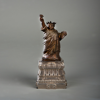

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features one of the first models of the Statue of Liberty, commonly known as the American Committee Model. Produced in the United States, this statuette was created in vast quantities, with the aim of funding the construction of the statue's pedestal in New York Harbor. The design, crafted by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes. A national campaign promoted these models, selling the six-inch version for one dollar and the twelve-inch version for five dollars, with the goal of raising enough money for the pedestal's construction. Richard Butler, a rubber manufacturer from New York, led the American Committee overseeing the production 

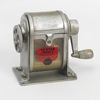

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920, produced by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.) and is part of the Cooper Hewitt, Smithsonian Design Museum collection, having been donated by Lucy Commoner. The Dexter sharpener is notable for its design, which includes a rotating wheel with calibrated openings for various pencil sizes, complemented by a fixed sharpener for smaller pencils. By the 1920s, APSCO had expanded its product line to include numerous sharpeners, each with unique styles and pricing. P

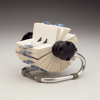

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases the Rolodex Open Rotary Card File, a quintessential office accessory produced by the Rolodex Corporation in the USA. Constructed from bent tubular metal, molded plastic, rubber, and paper, its dimensions are 18 x 18 x 16.5 cm (7 1/16 x 7 1/16 x 6 1/2 in.). The term "Rolodex" blends the words "rolling" and "index," accurately capturing its function as a rotating file for organizing business contacts on A-Z index cards. Despite the rise of digital technology, the Rolodex remains relevant, still available for purchase and utilized in modern workplaces. Invented by Arnold Neustadter, a visionary known for his innovative office products, the Rolodex was designed to simplify

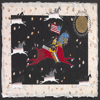

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the “Lakota Horse Mask,” a striking work by Jim Yellowhawk from 2008, created using acrylic on paper and gold leaf. This piece exemplifies the deep connection between American Indians and horses, often referred to as the Horse Nation. Horses have significantly influenced Native cultures, serving as essential allies in both peaceful and wartime contexts. Historically, horses first appeared in the Americas over 40 million years ago but became extinct until their reintroduction by Columbus in 1493. This artwork is part of the Smithsonian's National Museum of the American Indian collection and is showcased in the online exhibition “Horse Nation.” Visitors can also access a video that explores t

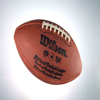

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a hallmark of American sports history, specifically from Super Bowl XIV, held on January 20, 1980, at the Rose Bowl in Pasadena, California. The Wilson Sporting Goods Company introduced this football in the early 1940s, characterized by high-quality leather, sewn ends, lock-stitch seams, and triple lining. It has been the official ball of the Super Bowl since Super Bowl II in 1968. The football highlighted in this exhibit was used during a thrilling championship game where the Pittsburgh Steelers defeated the Los Angeles Rams 31-19, marking the Steelers' fourth Super Bowl victory. Quarterback Terry Bradshaw also earned the Most Valuable Player award for the second

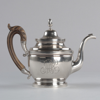

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a beautifully crafted silver teapot by Peter Bentzon, an American artisan active around 1783 to after 1850. The teapot showcases an elegant oval vase shape that rests on a spreading pedestal foot. It is adorned with a gracefully curved spout, crowned with an incised patera, and a scroll handle embellished with a wooden leaf cap. The hinged domed cover is topped with an acorn finial, enhancing its decorative appeal. The teapot is further personalized with the engraved monogram "MC" and the name "Rebecca Dawson" on the bottom rim, adding depth to its historical context. Measuring 7 inches in height and 12 inches in width, this piece is part of the Smithsonian National Museum of African Ameri

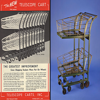

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit at the National Museum of American History features the Telescoping Shopping Cart, an innovative design created by Orla E. Watson in 1946. This cart, which made its debut in 1947 at Floyd's Super Market in Kansas City, Missouri, introduced a new way to shop by allowing multiple carts to nest together, thereby saving valuable storage space—each parked cart utilizing just one-fifth of the space of a conventional cart. The exhibit is part of the Smithsonian's first major food history exhibition, which highlights the significant shifts in food consumption and shopping habits in postwar America. To delve deeper into the evolution of food shopping and other culinary advancements, visitors can explore the 

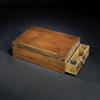

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary writing desk designed by Thomas Jefferson, which he used while drafting the Declaration of Independence in 1776. The desk, which includes a hinged writing board and a locking drawer for writing instruments, was crafted by Jefferson himself and showcases the artistry of American craftsmanship. The declaration, adopted on July 4, serves as a foundational document of American independence, articulating the colonies' desire for independence from Britain. Jefferson's desk accompanied him throughout his illustrious career, from his role as a revolutionary leader to his presidency. Notably, he sent this desk to his granddaughter as a wedding gift in 1825, attaching a note that hi

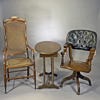

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact from the Civil War era: the chair used by General Ulysses S. Grant during the surrender negotiations with General Robert E. Lee on April 9, 1865, at Appomattox Court House, Virginia. This meeting was pivotal in the conclusion of the Civil War, as Grant's discussions with Lee ultimately led to the signing of the surrender agreement. The chair, made of wood and measuring 37 1/2 inches in height, is a symbol of this historic event. After the surrender, Union officers took pieces of the furniture as keepsakes, including Grant's chair and the table, which were later donated to the Smithsonian Institution. The chair, originally presented to Major General Custer's wife, was 

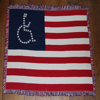

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-altered lap blanket that incorporates the universal access symbol, a tribute to the advocacy efforts of the American Disabled for Attendant Programs Today (ADAPT). Crafted by members of the disability rights movement, this cotton blanket, measuring 129 cm by 95 cm, serves as a powerful emblem of the fight for civil rights and independence for individuals with disabilities. ADAPT, founded in 1983 in Denver, emerged from the post-World War II era when disabled individuals began forming communities to share their experiences and push for political change. The blanket's design, adorned with stitched stars, emphasizes the message that freedom and independence belong to all. Although it i

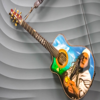

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer renowned for his vallenato music. Vallenato, a lively genre from Colombia's Atlantic coast, merges European instruments like the accordion with poetic lyrics and the traditional rhythms of the Arhuaco indigenous community. Originally, vallenato was performed primarily by rural workers and cowboys, but it gained wider recognition in the 1990s when Vives and other musicians began to incorporate pop and rock influences, allowing the genre to resonate with audiences beyond Colombia, including in the United States. The guitar on display, handmade by a Colombian luthier, showcases an airbrushed portrait of an Arhuaco and was las

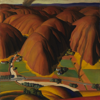

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking painting by Ross Dickinson, an artist whose work exemplifies the California landscape during the Great Depression. Created for the Public Works of Art Project, the painting captures the lush Central Valley, where a small river winds through vibrant green fields at the foot of dry, imposing hills. While the scene initially appears idyllic, Dickinson introduces elements of unease, such as a small fire in the foreground and a larger plume of smoke rising from the distant hills, which serve as a stark reminder of the wildfires that threaten the region. This duality encapsulates the beauty of California's landscape and the underlying tensions of hope amidst turmoil, making it a poign

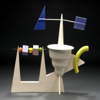

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Peter Shire, an influential artist born in Los Angeles in 1947. The centerpiece, Weathervane Teapot, exemplifies Shire's unique approach to ceramic art, blending vibrant colors with abstract forms. Constructed from glazed ceramic and wood, this teapot features an assemblage of geometric shapes, including balls and squares, along with swirling rods and hollow tubes. Shire's intention was to challenge and redefine the traditional notion of "tea-time," making it inclusive and accessible to all people. The teapot invites interaction, yet it poses questions about functionality, leaving viewers pondering how to pour from such an abstract object. After 1985, Shire shifted his focus to

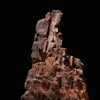

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Spotsylvania tree stump, a remarkable artifact from the Civil War era, located at the Smithsonian's National Museum of American History. The stump, dating back to 1864–65, was once part of a large oak tree that stood in a serene meadow near Spotsylvania Court House, Virginia. On May 12, 1864, the tranquility of the area was shattered as Confederate soldiers prepared for an assault by Union troops, leading to a fierce battle that would be remembered as the Bloody Angle. The oak tree, like many others, suffered the consequences of war, with several Minié balls embedded in its wood, serving as a stark reminder of the violence that unfolded. The Battle of Spotsylvania Court House, which oc

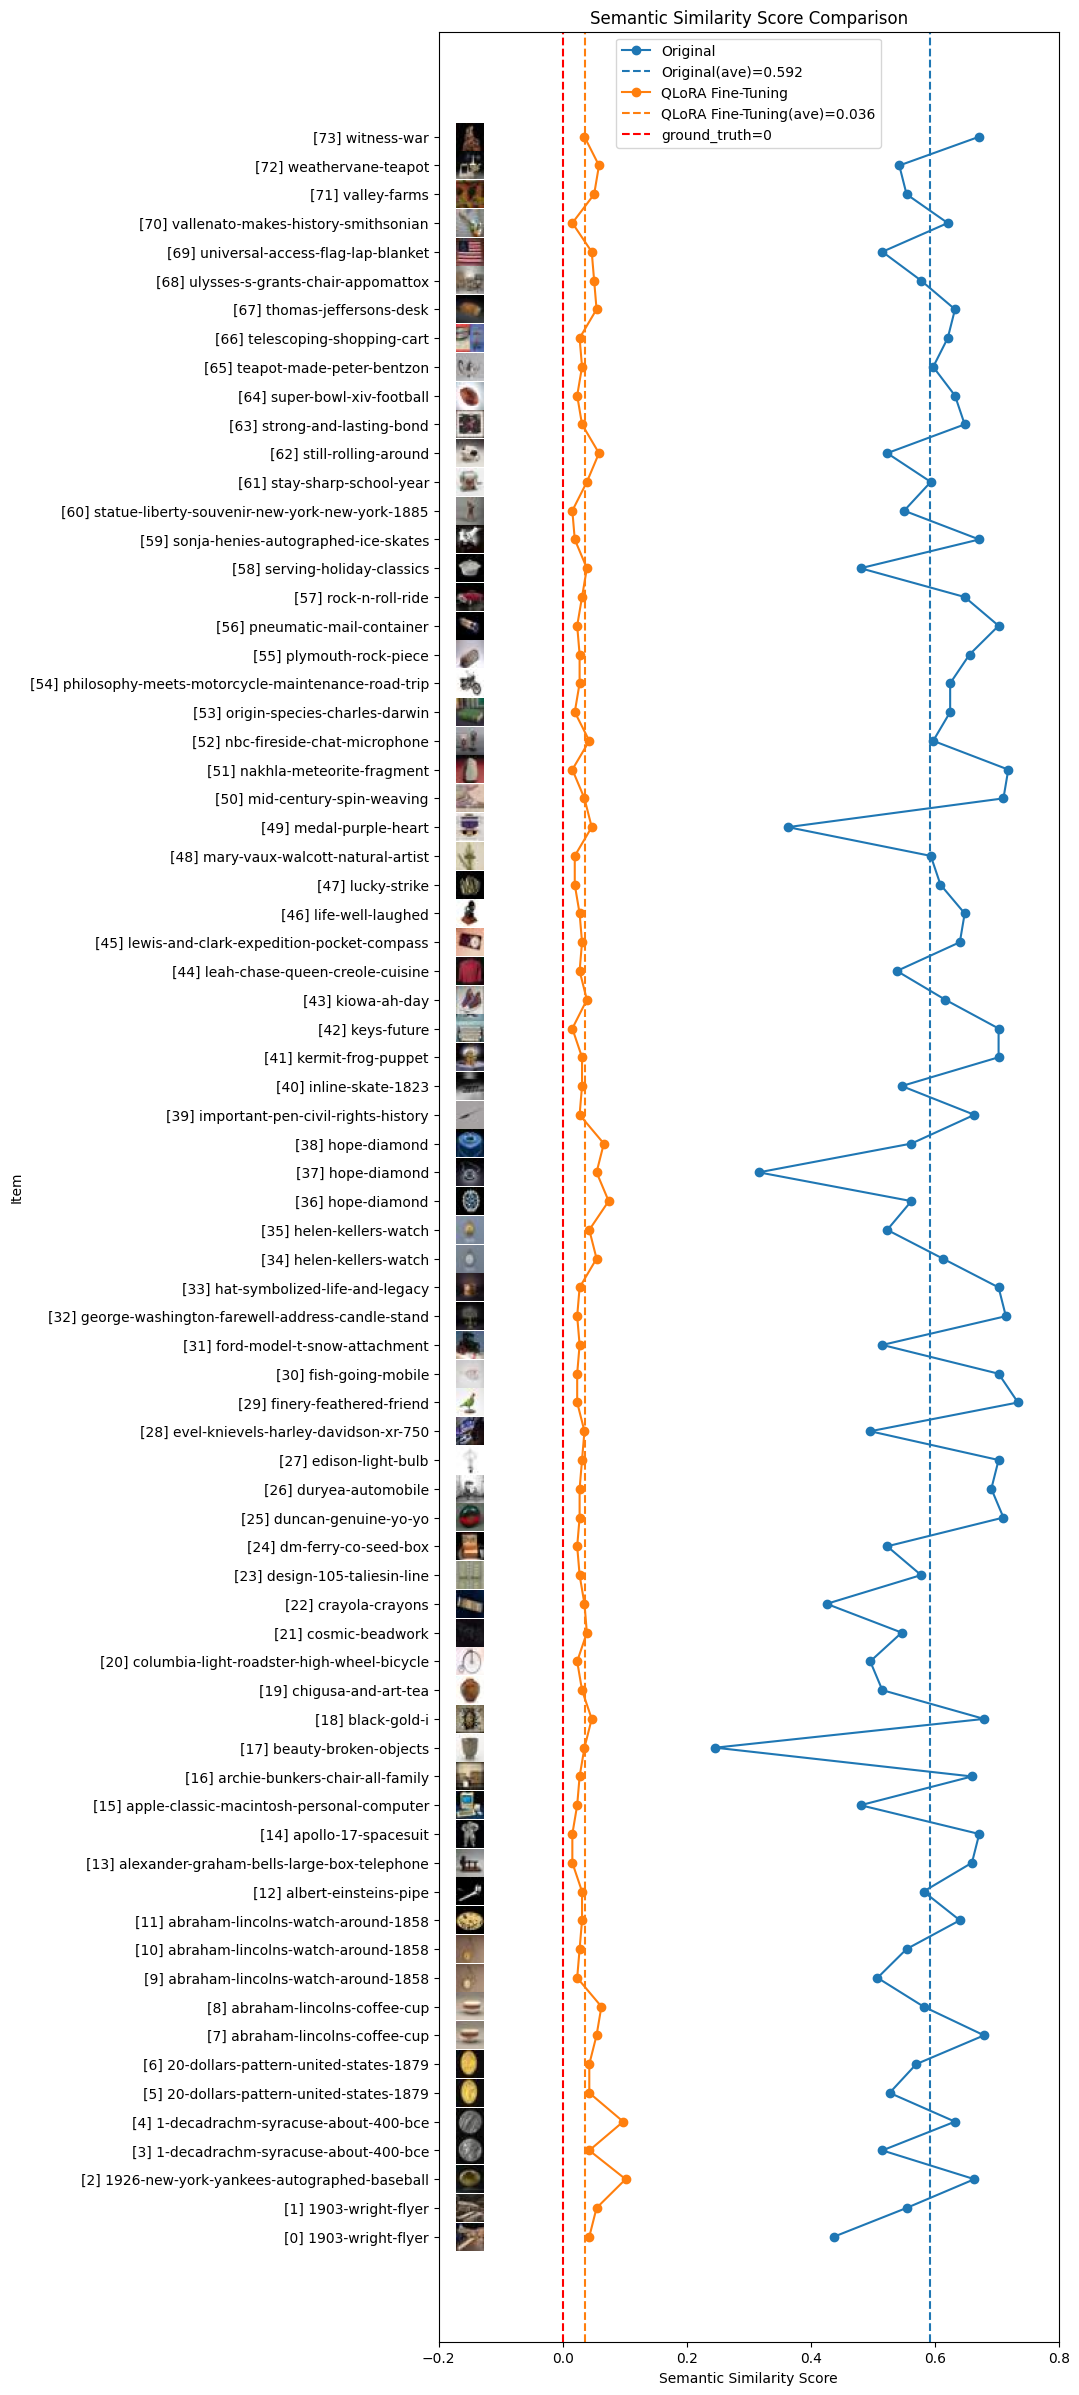

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(lora_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 2)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('QLoRA Fine-Tuning', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 4.4 Save the Fine-Tuned Model Locally  

In [3]:
# Merge base model with LoRA adapter
print(f'==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...')
merged_model = lora_model.merge_and_unload()

# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(merged_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(merged_model, './results/model_info/finetuned_model_parameters.txt')
merged_model.save_pretrained(save_directory='./results/finetuned_model')


==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (663552, torch.uint8, cuda, False)
model.vision_m